In [14]:
import os
os.chdir('/home/xinyue/Copilot')

Number of results per algorithm:
PC: 69
Number of results per algorithm:
DirectLiNGAM: 69
Number of results per algorithm:
InterIAMB: 69
Number of results per algorithm:
AcceleratedPC: 69
Number of results per algorithm:
IAMBnPC: 69
Number of results per algorithm:
HITONMB: 69
Number of results per algorithm:
FGES: 69
Number of results per algorithm:
GRaSP: 69
Number of results per algorithm:
XGES: 69
Number of results per algorithm:
GES: 69
Number of results per algorithm:
FCI: 69
Number of results per algorithm:
BAMB: 69
Number of results per algorithm:
CDNOD: 69
Number of results per algorithm:
NOTEARSLinear: 69
Number of results per algorithm:
MBOR: 64
AcceleratedLiNGAM: 5
Number of results per algorithm:
GOLEM: 69
Number of results per algorithm:
AcceleratedLiNGAM: 69
Number of results per algorithm:
MBOR: 69
Merged 2204 results into simulated_data/algorithm_benchmarking_results_v2/20250207_114523/merged_results.json

Algorithm Performance Ranking for Model Performance vs Number o

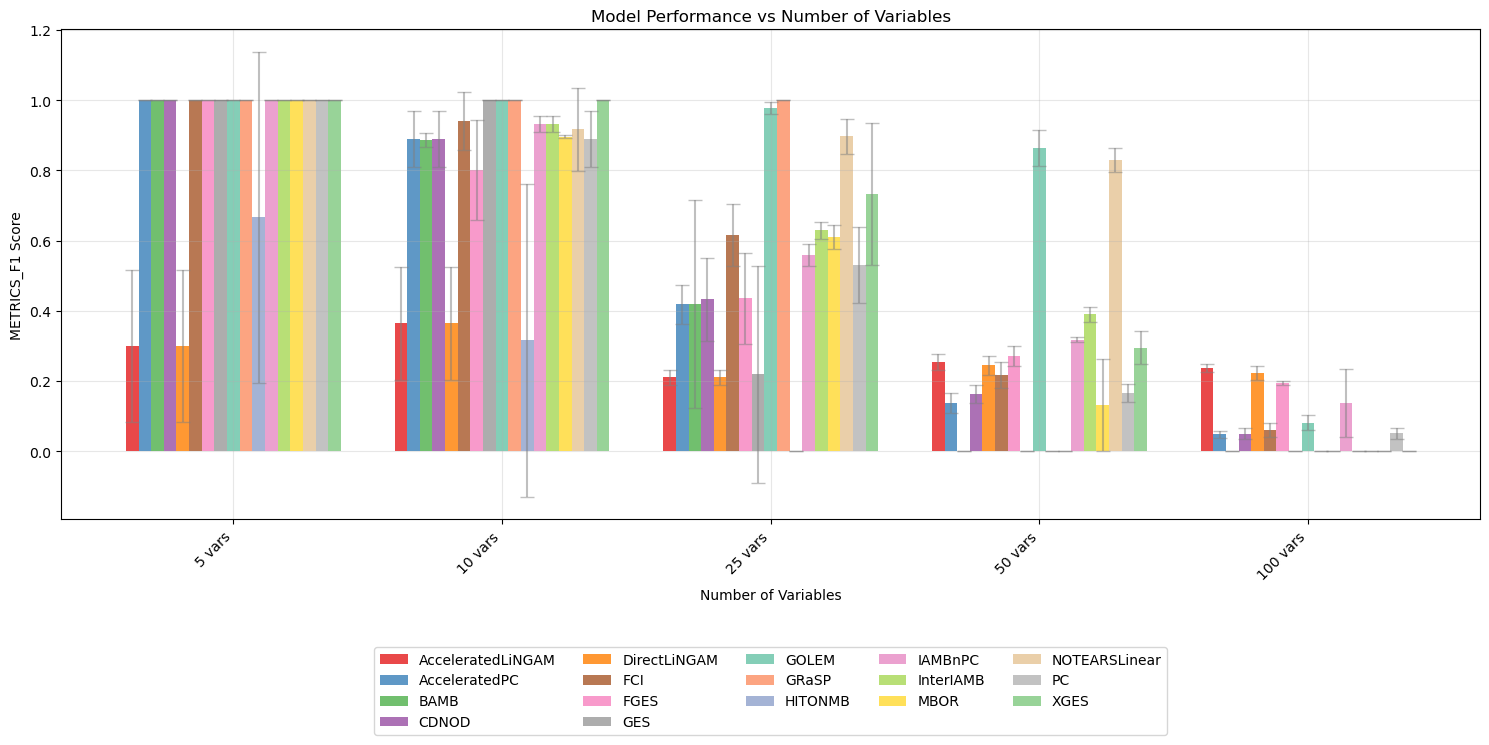

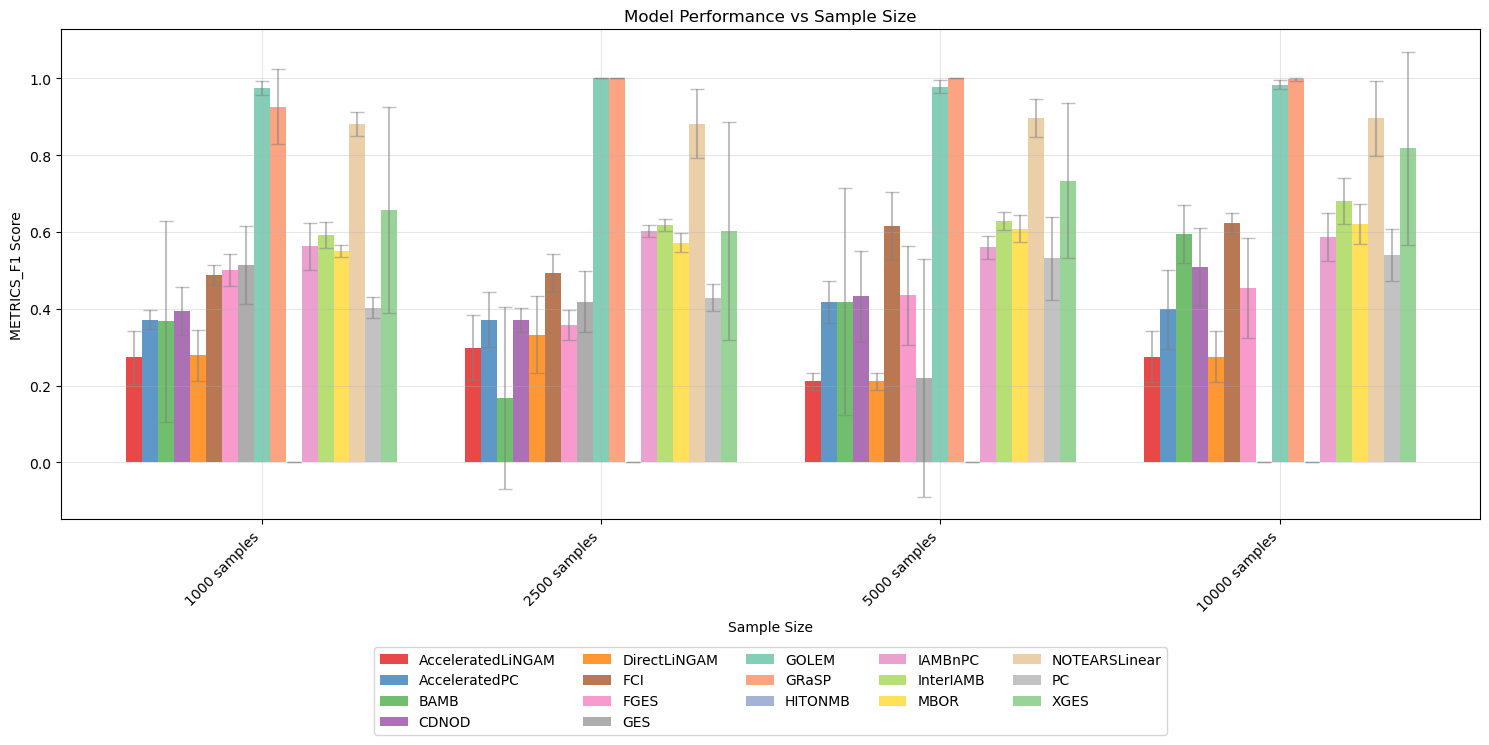

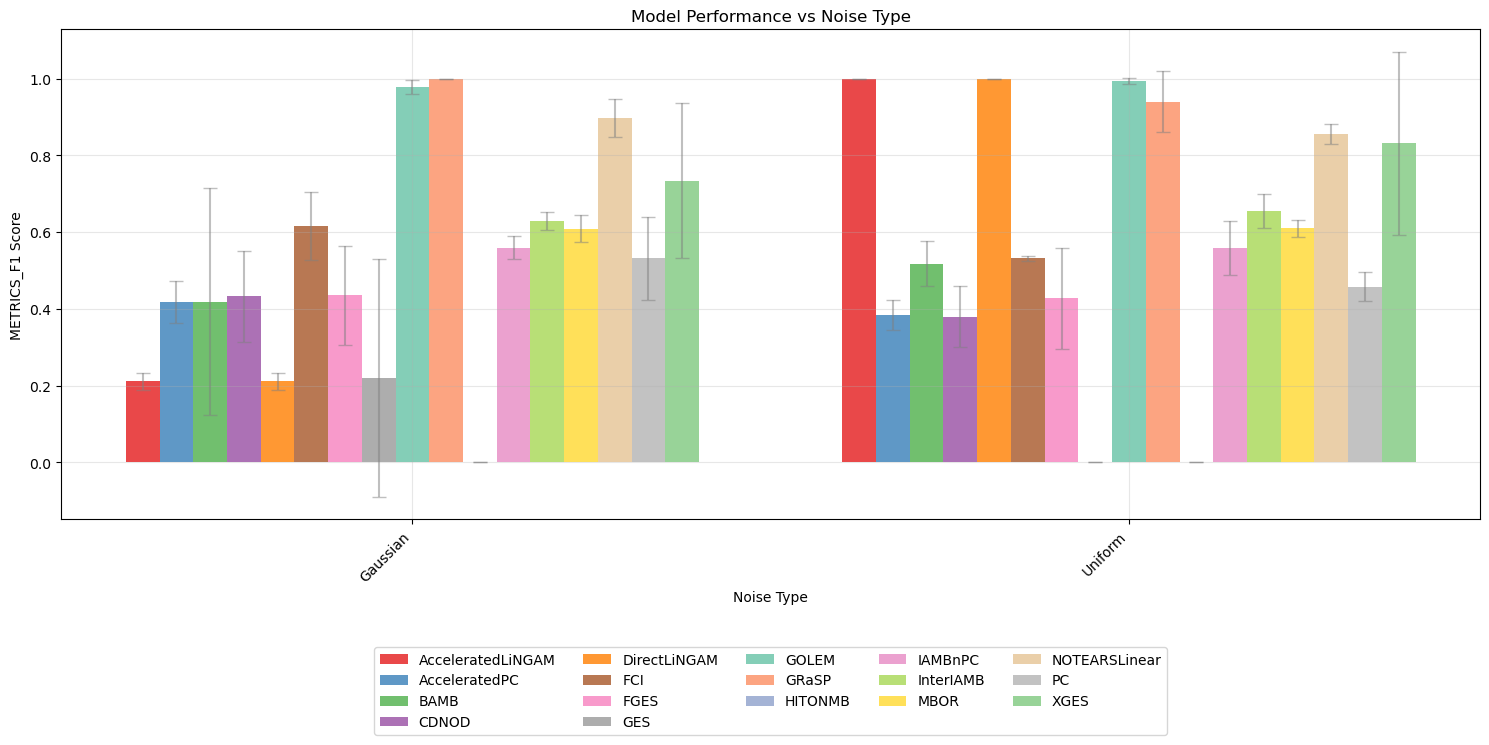

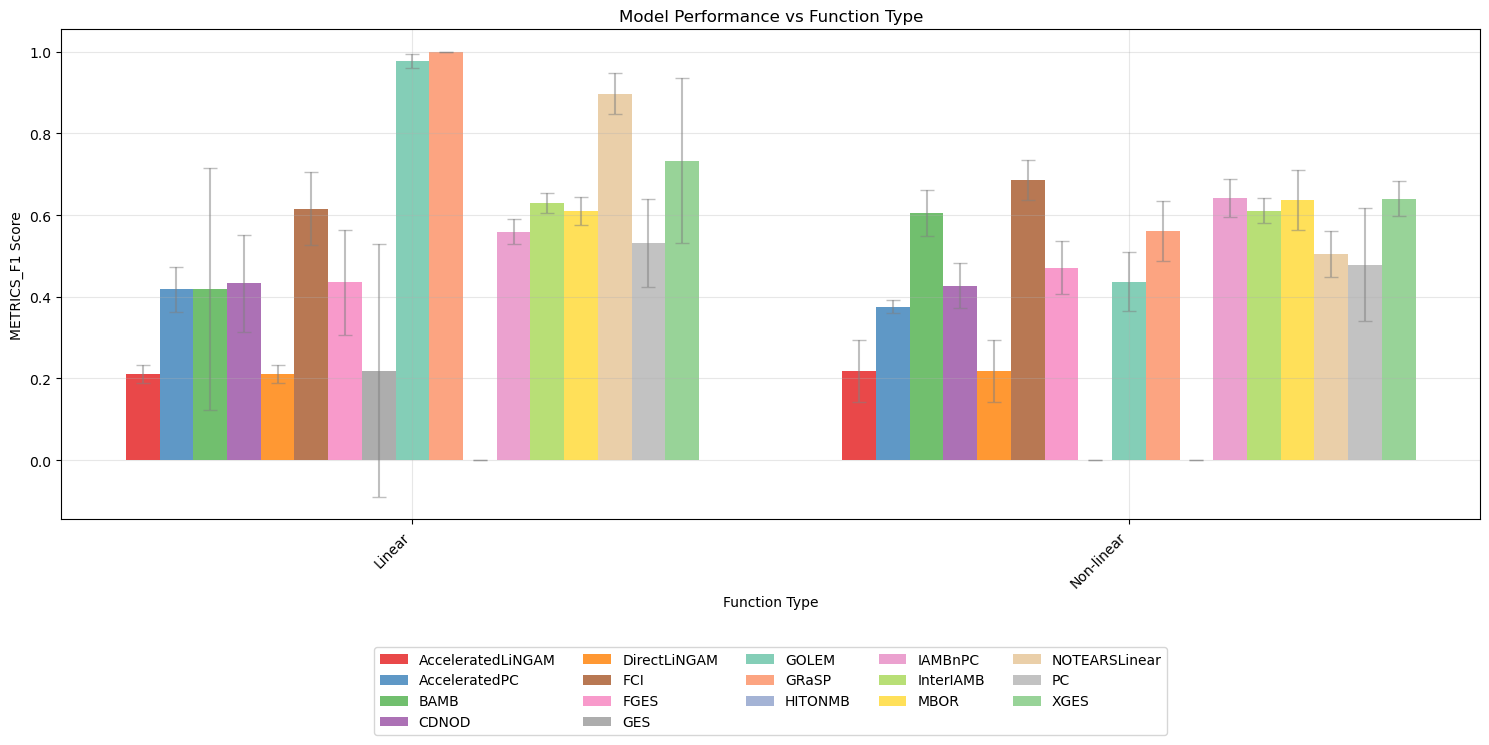

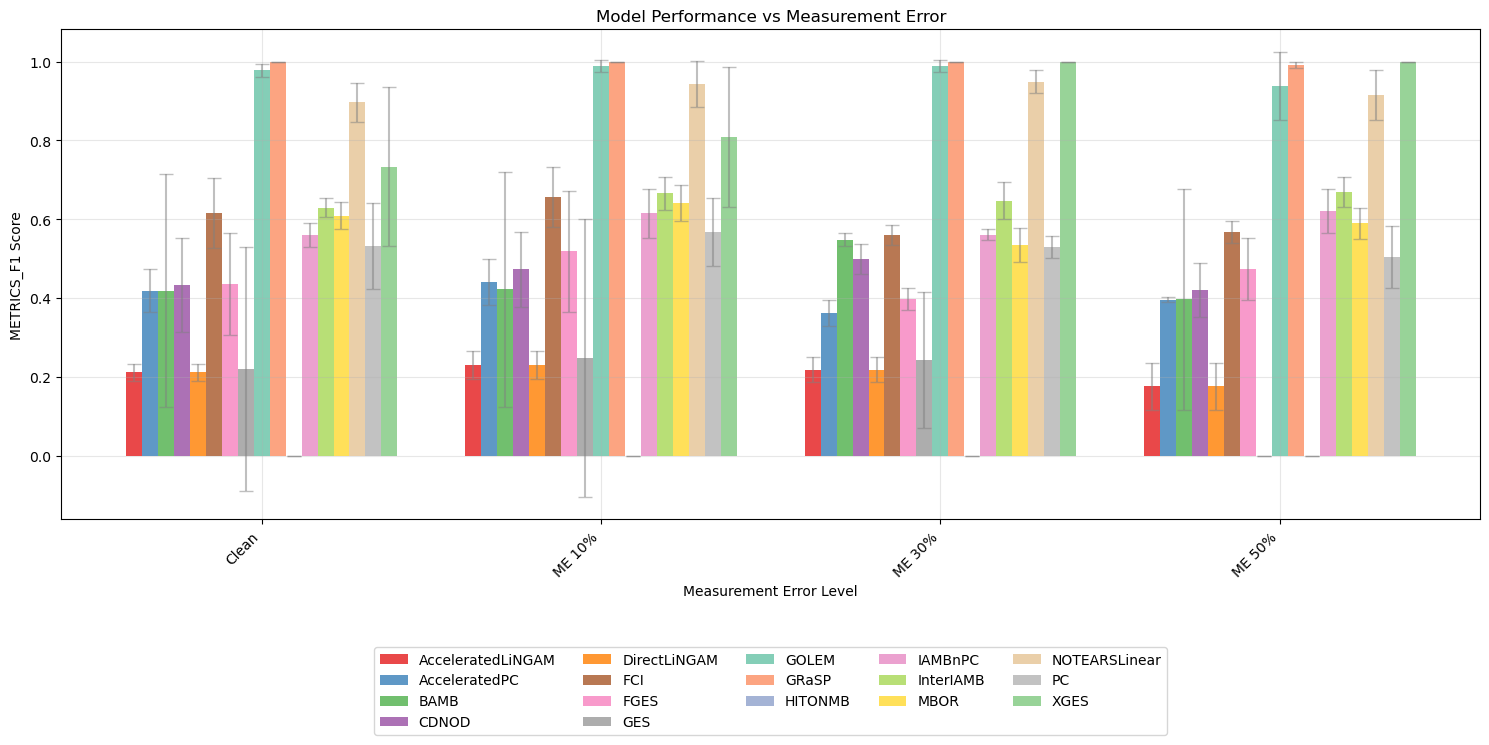

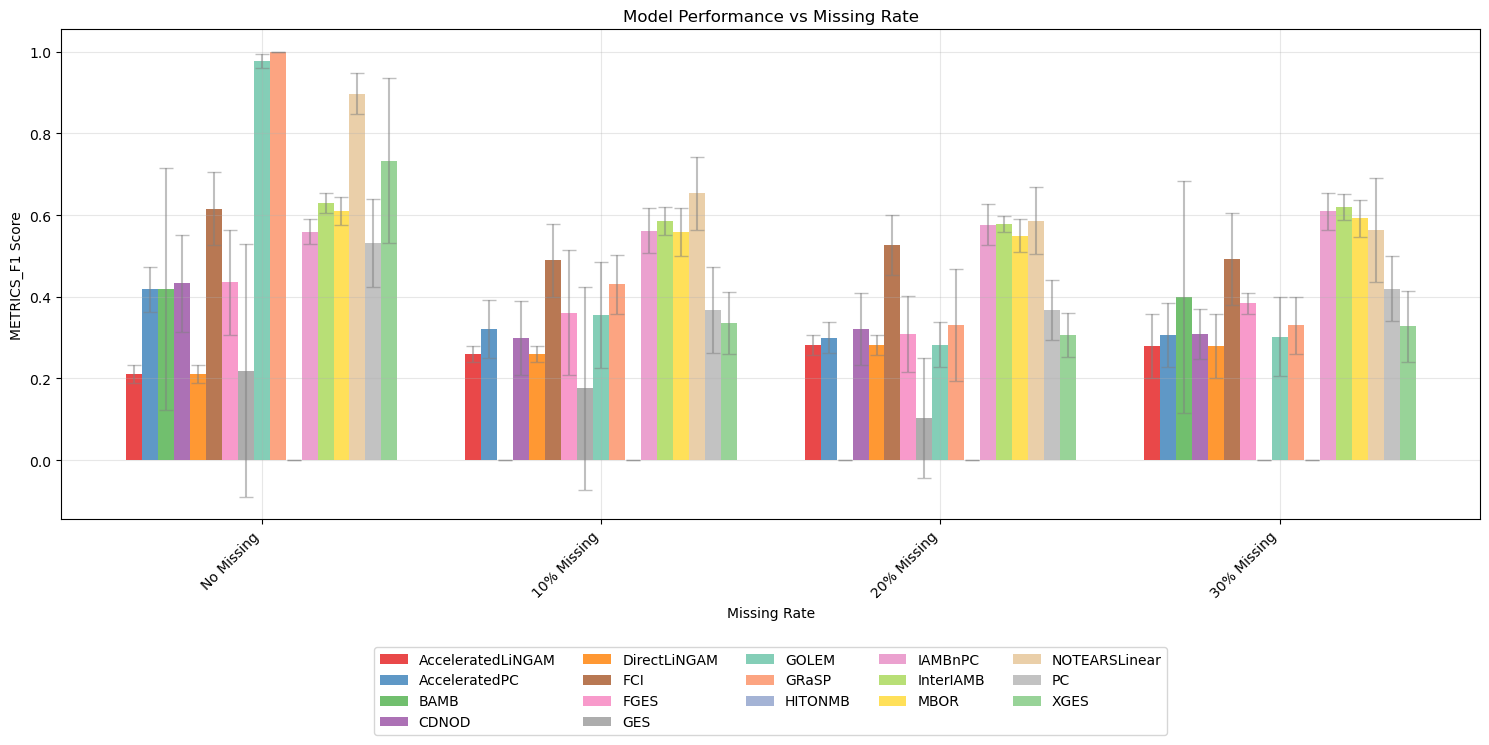

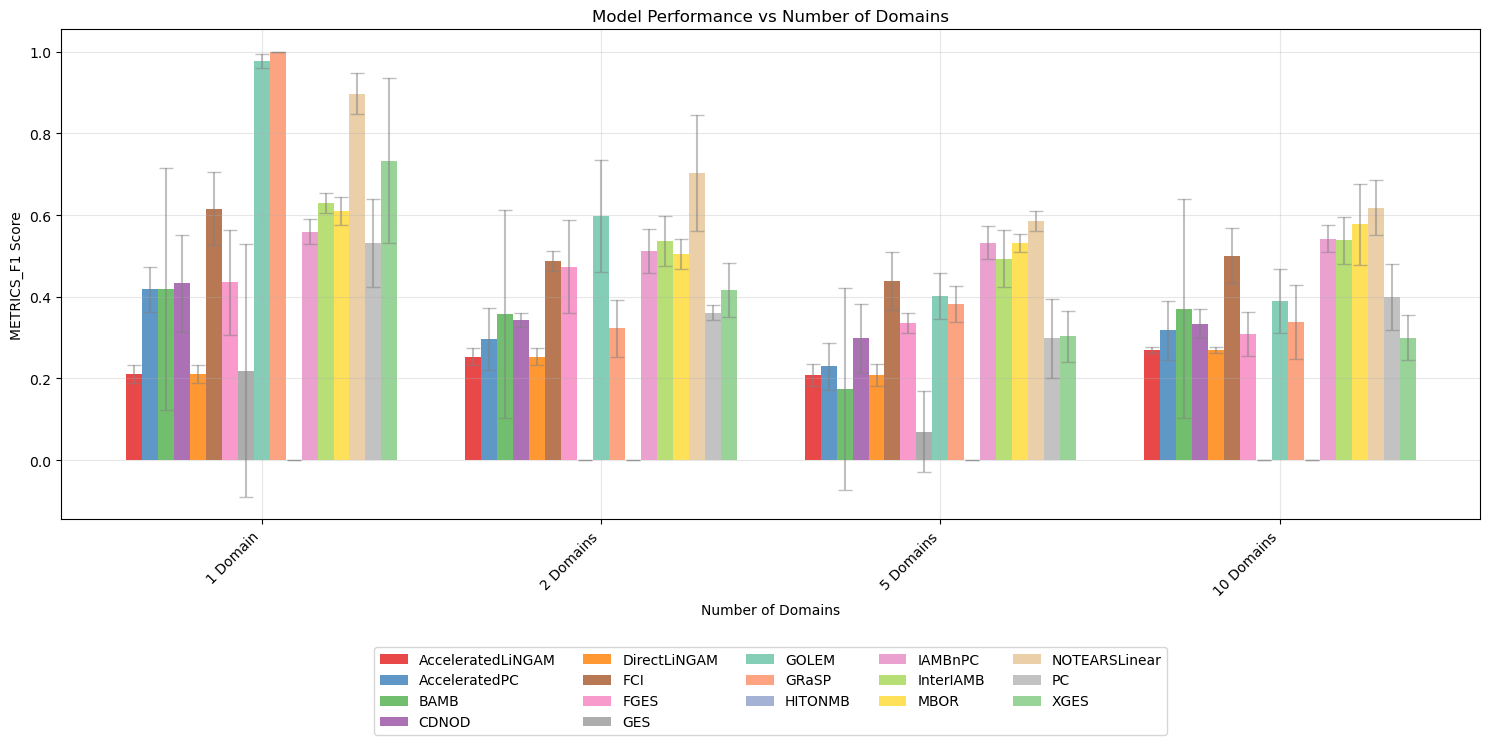

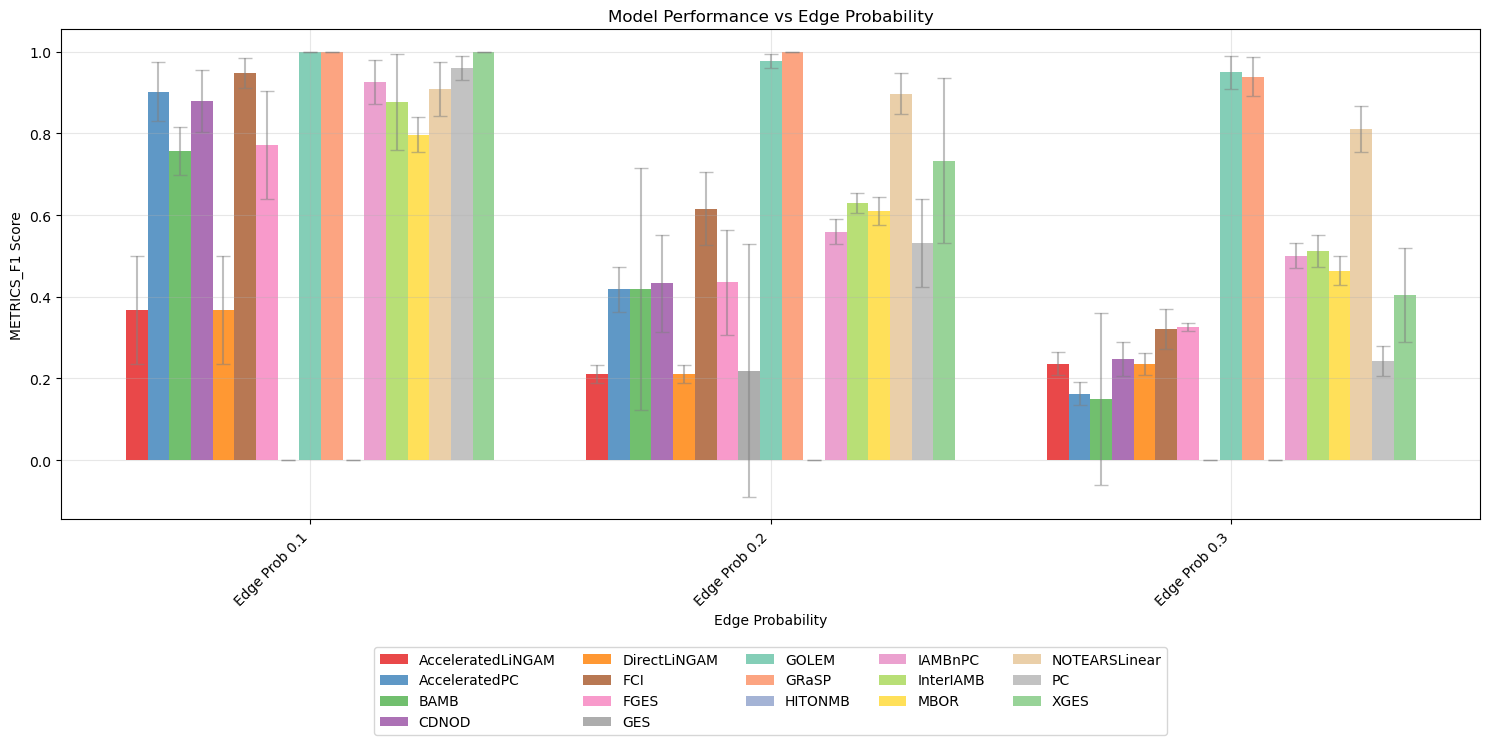

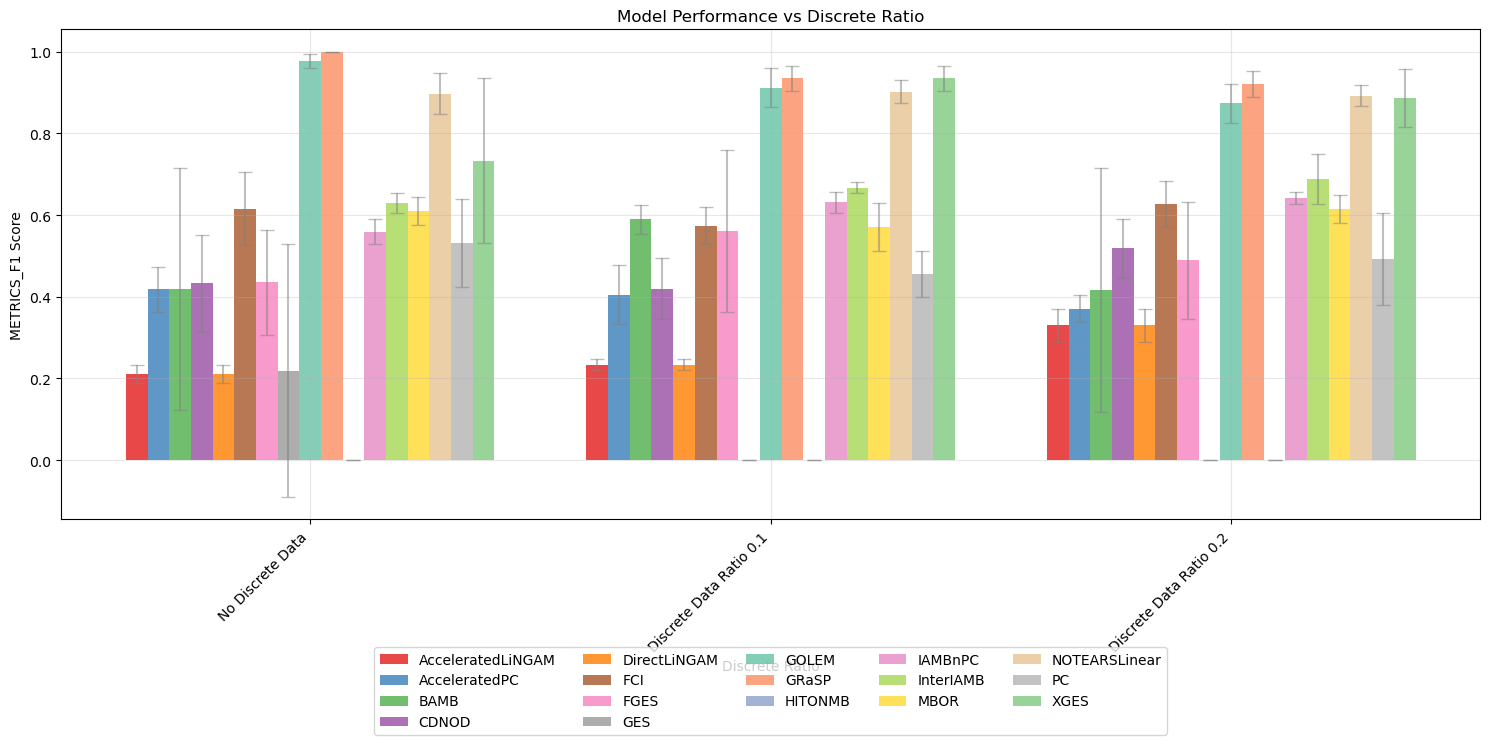

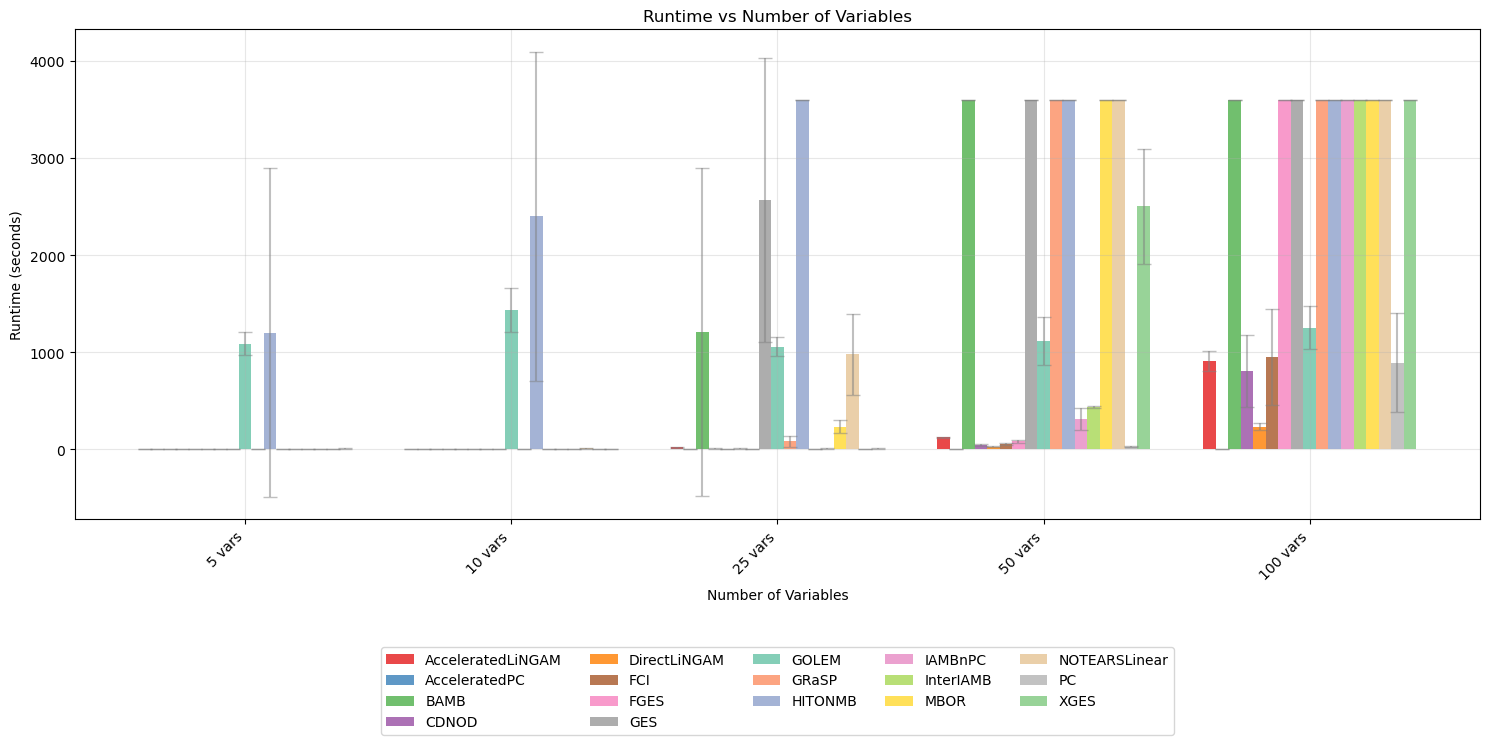

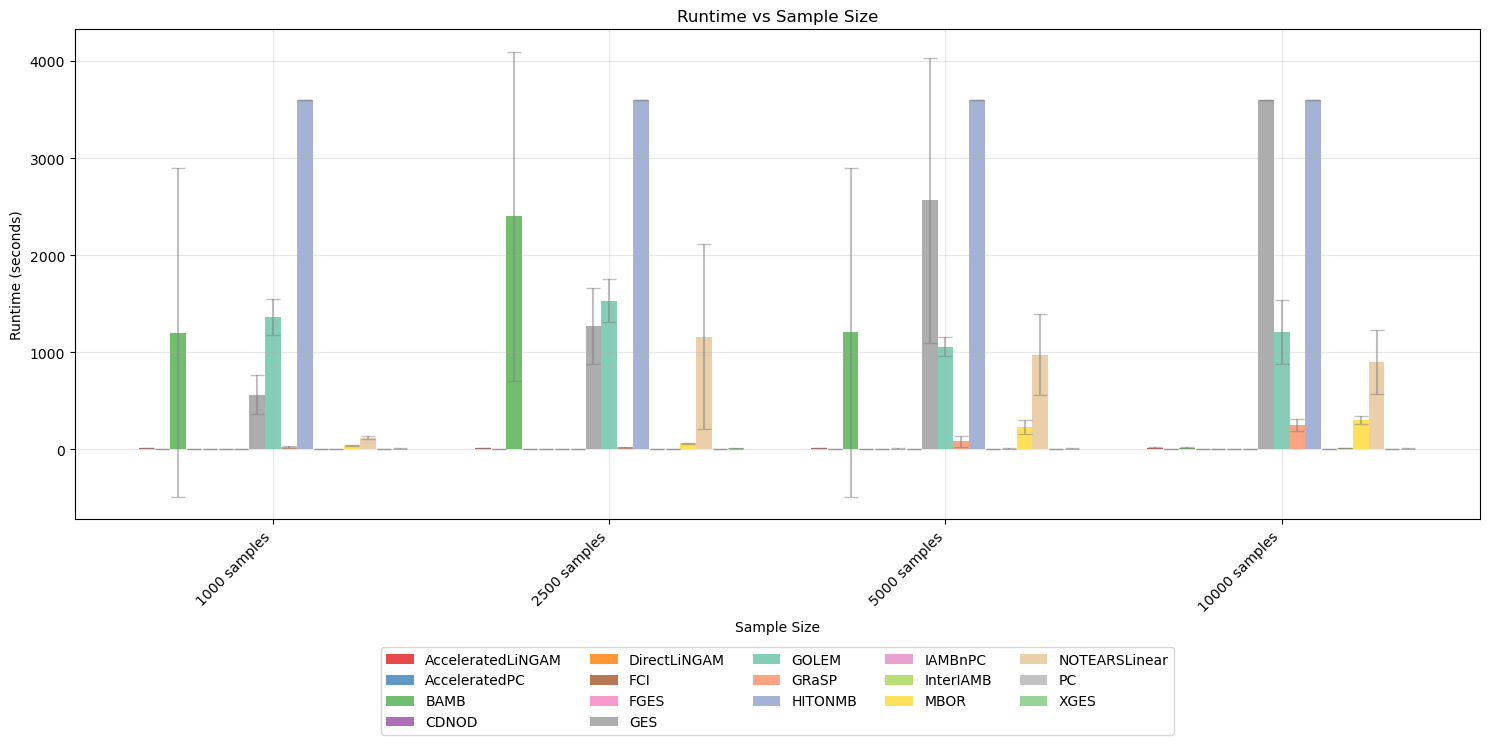

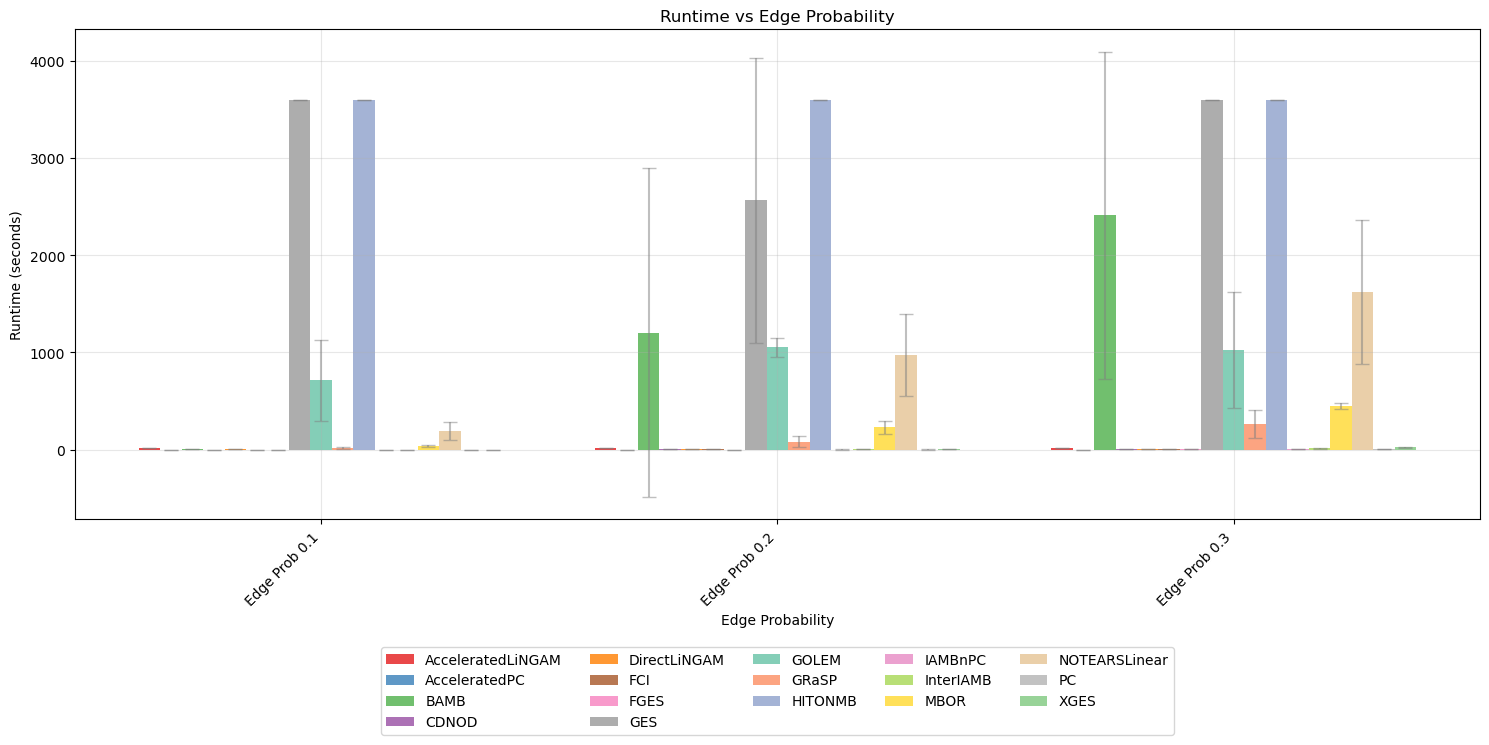

In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

default_settings = {
    "data_config_n_nodes": 25,
    "data_config_n_samples": 5000,
    "data_config_n_domains": 1,
    "data_config_noise_type": "gaussian",
    "data_config_function_type": "linear",
    "data_config_node_functions": None,
    "data_config_categorical": None,
    "data_config_missing_rate": None,
    "data_config_measurement_error": None,
    "data_config_edge_probability": 0.2,
    "data_config_discrete_ratio": 0.0,
    "data_config_max_categories": 5,
}

def flatten_dict(d, parent_key='', sep='_'):
    """
    Recursively flatten a nested dictionary, joining keys with separator.
    Skip None values and best_graph (which is a large string matrix).
    """
    items = []
    for k, v in d.items():
        if k == 'best_graph':  # Skip best_graph and None values
            continue
            
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def flatten_results(results):
    """
    Flatten each result dictionary in the results list.
    """
    flattened = []
    for result in results:
        flat_result = flatten_dict(result)
        flattened.append(flat_result)
    return flattened


def merge_results(directory='simulated_data/algorithm_benchmarking_results/'):
    """
    Merge all json results under a directory into a single json file.
    """
    all_results = []
    
    # Walk through directory and collect all results
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(root, file), 'r') as f:
                    results = json.load(f)
                    all_results.extend(results)
    
    # Save merged results
    output_path = os.path.join(directory, 'merged_results.json')
    with open(output_path, 'w') as f:
        json.dump(all_results, f, indent=4)
        
    print(f"Merged {len(all_results)} results into {output_path}")
    return all_results


def load_results(directory='simulated_data/algorithm_benchmarking_results/', pad_results=True):
    """Load all json results from the directory"""
    results = []
    if pad_results:
        # assume AcceleratedLiNGAM is the reference algorithm
        reference_results = json.load(open(f'{directory}/AcceleratedLiNGAM_results.json'))
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(root, file), 'r') as f:
                    if pad_results:
                        results.extend(fill_results(json.load(f), reference_results))
                    else:
                        results.extend(json.load(f))
    results = flatten_results(results)
    return results

def fill_results(target_list, reference_list):
    """Fill missing or failed runs in target list with placeholder values based on reference list"""
    
    # Create lookup of existing successful runs in target list
    target_runs = {r['dataset']: r for r in target_list if r.get('success', False)}

    target_run_example = target_list[0]
    
    # Create placeholder metrics
    placeholder_run = {
        "success": True,
        "metrics_precision": 0,
        "metrics_recall": 0,
        "metrics_f1": 0,
        "metrics_shd": 0,
        "metrics_best_graph": None,
        "runtime": 3600,
        "algorithm": target_run_example['algorithm'],
    }
    
    filled_results = []
    
    # Go through reference list and fill missing/failed runs
    for ref_run in reference_list:
        dataset = ref_run['dataset']
        
        if dataset in target_runs and target_runs[dataset].get('success', False):
            # Use existing successful run
            filled_results.append(target_runs[dataset])
        else:
            # Create placeholder run for the missing dataset that the algorithm can not finish (e.g. BAMB)
            # We ignore the params part in the following
            placeholder_run = ref_run.copy()
            placeholder_run.update({'algorithm': target_run_example['algorithm'],
                                    'success': True,
                                    'metrics_precision': 0,
                                    'metrics_recall': 0,
                                    'metrics_f1': 0,
                                    'metrics_shd': 0,
                                    'metrics_best_graph': None,
                                    'runtime': 3600,
                                    })
            filled_results.append(placeholder_run)
            
    # Print number of results for each algorithm
    algorithm_counts = {}
    for result in filled_results:
        alg = result['algorithm']
        algorithm_counts[alg] = algorithm_counts.get(alg, 0) + 1
    
    print("Number of results per algorithm:")
    for alg, count in algorithm_counts.items():
        print(f"{alg}: {count}")
    
    return filled_results


def filter_results(results, **kwargs):
    default = default_settings.copy()
    default.update(kwargs)
    kwargs = default
    """Filter results based on data config parameters"""
    filtered = []
    for result in results:
        if not result.get('success', False):
            continue
            
        config = result
        match = True
        for key, value in kwargs.items():
            if key == 'data_config_seed':
                continue
            if key == 'data_config_missing_rate':
                if value is None:
                    if key not in config or config[key] != value:
                        match = False
                        break
                elif not any([k for k in config if key in k]) or str([config[k] for k in config if key in k][0]) != value:
                    match = False
                    break
            elif key == 'data_config_measurement_error':
                import math
                if value is None:
                    if key not in config or config[key] != value:
                        match = False
                        break
                elif not any([k for k in config if key in k]) or str(math.ceil(len([config[k] for k in config if key in k])/kwargs['data_config_n_nodes']*10)/10) != value:
                    match = False
                    break
            else:
                if key not in config or config[key] != value:
                    match = False
                    break
        if match:
            filtered.append(result)
    return filtered

def get_algorithm_ranking(results_dict, metric='metrics_f1'):
    """Get ranking of algorithms based on mean performance"""
    algorithm_scores = defaultdict(list)
    
    # Collect all scores for each algorithm
    for results in results_dict.values():
        for r in results:
            value = r.get(metric, 0)
            try:
                value = float(value)
            except (ValueError, TypeError):
                value = 0
            algorithm_scores[r['algorithm']].append(value)
    
    # Calculate mean scores and sort
    mean_scores = {alg: np.mean(scores) for alg, scores in algorithm_scores.items()}
    ranked_algorithms = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)
    
    return ranked_algorithms

def get_runtime_ranking(results_dict):
    """Get ranking of algorithms based on mean runtime"""
    algorithm_times = defaultdict(list)
    
    # Collect all runtimes for each algorithm
    for results in results_dict.values():
        for r in results:
            algorithm_times[r['algorithm']].append(min(r.get('runtime', 3600), 3600))
    
    # Calculate mean runtimes and sort
    mean_times = {alg: np.mean(times) for alg, times in algorithm_times.items()}
    ranked_algorithms = sorted(mean_times.items(), key=lambda x: x[1])
    
    return ranked_algorithms

def plot_model_comparison(results_dict, metric='metrics_f1', title='', xlabel='', figsize=(15,8)):
    """Plot comparison of metrics across different models and configurations"""
    plt.figure(figsize=figsize)
    
    # Get unique configs and models
    configs = list(results_dict.keys())
    models = sorted(list({result['algorithm'] for results in results_dict.values() for result in results}))

    # Prepare data for grouped bar plot
    n_configs = len(configs)
    n_models = len(models)
    bar_width = 0.8 / n_models
    
    # Create positions for bars
    indices = np.arange(n_configs)
    
    # Define distinct colors
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
              '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62',
              '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494',
              '#b3b3b3', '#7fc97f', '#beaed4', '#fdc086', '#ffff99']
    
    # Plot bars for each model
    for i, model in enumerate(models):
        means = []
        stds = []
        for config_results in results_dict.values():
            model_metrics = []
            for r in config_results:
                if r['algorithm'] == model:
                    value = r.get(metric, 0) if metric != 'runtime' else min(r.get('runtime', 3600), 3600)
                    try:
                        value = float(value)
                    except (ValueError, TypeError):
                        value = 0
                    model_metrics.append(value)
            means.append(np.mean(model_metrics) if model_metrics else 0)
            stds.append(np.std(model_metrics) if model_metrics else 0)
        
        positions = indices + (i - n_models/2 + 0.5) * bar_width
        plt.bar(positions, means, bar_width, label=model, color=colors[i % len(colors)], alpha=0.8)
        plt.errorbar(positions, means, yerr=stds, fmt='none', color='gray', alpha=0.5, capsize=5)
    plt.title(title)
    plt.ylabel('Runtime (seconds)' if metric == 'runtime' else metric.upper() + ' Score')
    if xlabel:
        plt.xlabel(xlabel)
    plt.grid(True, alpha=0.3)
    plt.xticks(indices, configs, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=len(models)//3)
    plt.tight_layout()
    
    # Print algorithm ranking
    ranked_algorithms = get_algorithm_ranking(results_dict, metric)
    print(f"\nAlgorithm Performance Ranking for {title}:")
    for rank, (alg, score) in enumerate(ranked_algorithms, 1):
        print(f"{rank}. {alg}: {score:.3f}")
        
    # Print runtime ranking
    runtime_ranking = get_runtime_ranking(results_dict)
    print(f"\nAlgorithm Runtime Ranking for {title}:")
    for rank, (alg, runtime) in enumerate(runtime_ranking, 1):
        print(f"{rank}. {alg}: {runtime:.3f}s")
    
def plot_runtime_comparison(results):
    """Plot runtime comparison across different dimensions"""
    # Variable count comparison
    var_configs = {
        '5 vars': {'data_config_n_nodes': 5, 'data_config_n_samples': 5000},
        '10 vars': {'data_config_n_nodes': 10, 'data_config_n_samples': 5000}, 
        '25 vars': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000},
        '50 vars': {'data_config_n_nodes': 50, 'data_config_n_samples': 5000},
        '100 vars': {'data_config_n_nodes': 100, 'data_config_n_samples': 5000}
    }
    
    var_results = {
        label: filter_results(results, **config)
        for label, config in var_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in var_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(var_results, 
                       metric='runtime',
                       title='Runtime vs Number of Variables',
                       xlabel='Number of Variables')
    
    # Sample size comparison  
    sample_configs = {
        '1000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 1000},
        '2500 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 2500},
        '5000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000},
        '10000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 10000}
    }
    
    sample_results = {
        label: filter_results(results, **config)
        for label, config in sample_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in sample_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(sample_results,
                       metric='runtime',
                       title='Runtime vs Sample Size',
                       xlabel='Sample Size')
    
    # Edge probability comparison
    edge_configs = {
        'Edge Prob 0.1': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.1},
        'Edge Prob 0.2': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.2},
        'Edge Prob 0.3': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.3}
    }

    edge_results = {
        label: filter_results(results, **config)
        for label, config in edge_configs.items()
    }
    
        
    plot_model_comparison(edge_results,
                       metric='runtime',
                       title='Runtime vs Edge Probability',
                       xlabel='Edge Probability')
    

def compare_scale(results):
    """Compare model performance across different scales"""
    # Variable count comparison
    var_configs = {
        '5 vars': {'data_config_n_nodes': 5, 'data_config_n_samples': 5000},
        '10 vars': {'data_config_n_nodes': 10, 'data_config_n_samples': 5000}, 
        '25 vars': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000},
        '50 vars': {'data_config_n_nodes': 50, 'data_config_n_samples': 5000},
        '100 vars': {'data_config_n_nodes': 100, 'data_config_n_samples': 5000}
    }
    
    var_results = {
        label: filter_results(results, **config)
        for label, config in var_configs.items()
    }

    # # Check number of results per algorithm
    # for label, filtered_results in var_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     if '25 vars' in label:
    #         print([f for f in filtered_results if f['algorithm'] == 'BAMB'])
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")

    plot_model_comparison(var_results, 
                       title='Model Performance vs Number of Variables',
                       xlabel='Number of Variables')
    
    # Sample size comparison  
    sample_configs = {
        '1000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 1000},
        '2500 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 2500},
        '5000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000},
        '10000 samples': {'data_config_n_nodes': 25, 'data_config_n_samples': 10000}
    }
    
    sample_results = {
        label: filter_results(results, **config)
        for label, config in sample_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in sample_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(sample_results,
                       title='Model Performance vs Sample Size', 
                       xlabel='Sample Size')
    

def compare_noise_type(results):
    """Compare model performance with different noise types"""
    noise_configs = {
        'Gaussian': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_noise_type': 'gaussian'},
        'Uniform': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_noise_type': 'uniform'}
    }
    
    noise_results = {
        label: filter_results(results, **config)
        for label, config in noise_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in noise_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(noise_results,
                       title='Model Performance vs Noise Type',
                       xlabel='Noise Type')

def compare_function_type(results):
    """Compare model performance with different function types"""
    func_configs = {
        'Linear': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_function_type': 'linear'},
        'Non-linear': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_function_type': 'mlp'}
    }
    
    func_results = {
        label: filter_results(results, **config)
        for label, config in func_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in func_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(func_results,
                       title='Model Performance vs Function Type',
                       xlabel='Function Type')

def compare_data_quality(results):
    """Compare model performance with different data quality issues"""
    # Filter for measurement error results
    me_configs = {
        'Clean': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_measurement_error': None},
        'ME 10%': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_measurement_error': '0.1'},
        'ME 30%': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_measurement_error': '0.3'},
        'ME 50%': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_measurement_error': '0.5'}
    }
    
    me_results = {
        label: filter_results(results, **config)
        for label, config in me_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in me_results.items():
    #     print(f"\nResults count for {label}:")
    #     if 'No' in label:
    #         print([f for f in filtered_results if f['algorithm'] == 'GES'])
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
                
    plot_model_comparison(me_results,
                       title='Model Performance vs Measurement Error',
                       xlabel='Measurement Error Level')
    
def compare_missing_rate(results):
    """Compare model performance with different missing rates"""
    missing_configs = {
        'No Missing': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_missing_rate': None},
        '10% Missing': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_missing_rate': '0.1'},
        '20% Missing': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_missing_rate': '0.2'},
        '30% Missing': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_missing_rate': '0.3'}
    }  

    missing_results = {
        label: filter_results(results, **config)
        for label, config in missing_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in missing_results.items():
    #     print(f"\nResults count for {label}:")
    #     if 'No' in label:
    #         print(filtered_results)
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(missing_results,
                       title='Model Performance vs Missing Rate',
                       xlabel='Missing Rate')   
    
def compare_heterogeneity(results):
    """Compare model performance with different numbers of domains"""
    domain_configs = {
        '1 Domain': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_n_domains': 1},
        '2 Domains': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_n_domains': 2},
        '5 Domains': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_n_domains': 5},
        '10 Domains': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_n_domains': 10}
    }
    
    domain_results = {
        label: filter_results(results, **config)
        for label, config in domain_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in domain_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(domain_results,
                       title='Model Performance vs Number of Domains',
                       xlabel='Number of Domains')

def compare_edge_probability(results):
    """Compare model performance with different edge probabilities"""
    edge_configs = {
        'Edge Prob 0.1': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.1},
        'Edge Prob 0.2': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.2},
        'Edge Prob 0.3': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_edge_probability': 0.3}
    }
    
    edge_results = {
        label: filter_results(results, **config)
        for label, config in edge_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in edge_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(edge_results,
                       title='Model Performance vs Edge Probability',
                       xlabel='Edge Probability')
    
def compare_discrete_ratio(results):
    """Compare model performance with different discrete ratios"""
    discrete_configs = {
        'No Discrete Data': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.0},
        'Discrete Data Ratio 0.1': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.1},
        'Discrete Data Ratio 0.2': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.2}
    }
    
    discrete_results = {
        label: filter_results(results, **config)
        for label, config in discrete_configs.items()
    }
    
    # # Check number of results per algorithm
    # for label, filtered_results in discrete_results.items():
    #     print(f"\nResults count for {label}:")
    #     alg_counts = {}
    #     for r in filtered_results:
    #         alg = r['algorithm']
    #         alg_counts[alg] = alg_counts.get(alg, 0) + 1
    #     for alg, count in alg_counts.items():
    #         print(f"{alg}: {count} results")
    
    plot_model_comparison(discrete_results,
                          title='Model Performance vs Discrete Ratio',
                          xlabel='Discrete Ratio')

# Load and plot results
results = load_results('simulated_data/algorithm_benchmarking_results_v2/20250207_114523')
merge_results('simulated_data/algorithm_benchmarking_results_v2/20250207_114523')

compare_scale(results)
compare_noise_type(results)
compare_function_type(results)
compare_data_quality(results)
compare_missing_rate(results)
compare_heterogeneity(results)
compare_edge_probability(results)
compare_discrete_ratio(results)
plot_runtime_comparison(results)



Number of results per algorithm:
PC: 69
Number of results per algorithm:
DirectLiNGAM: 69
Number of results per algorithm:
InterIAMB: 69
Number of results per algorithm:
AcceleratedPC: 69
Number of results per algorithm:
IAMBnPC: 69
Number of results per algorithm:
HITONMB: 69
Number of results per algorithm:
FGES: 69
Number of results per algorithm:
GRaSP: 69
Number of results per algorithm:
XGES: 69
Number of results per algorithm:
GES: 69
Number of results per algorithm:
FCI: 69
Number of results per algorithm:
BAMB: 69
Number of results per algorithm:
CDNOD: 69
Number of results per algorithm:
NOTEARSLinear: 69
Number of results per algorithm:
MBOR: 64
AcceleratedLiNGAM: 5
Number of results per algorithm:
GOLEM: 69
Number of results per algorithm:
AcceleratedLiNGAM: 69
Number of results per algorithm:
MBOR: 69


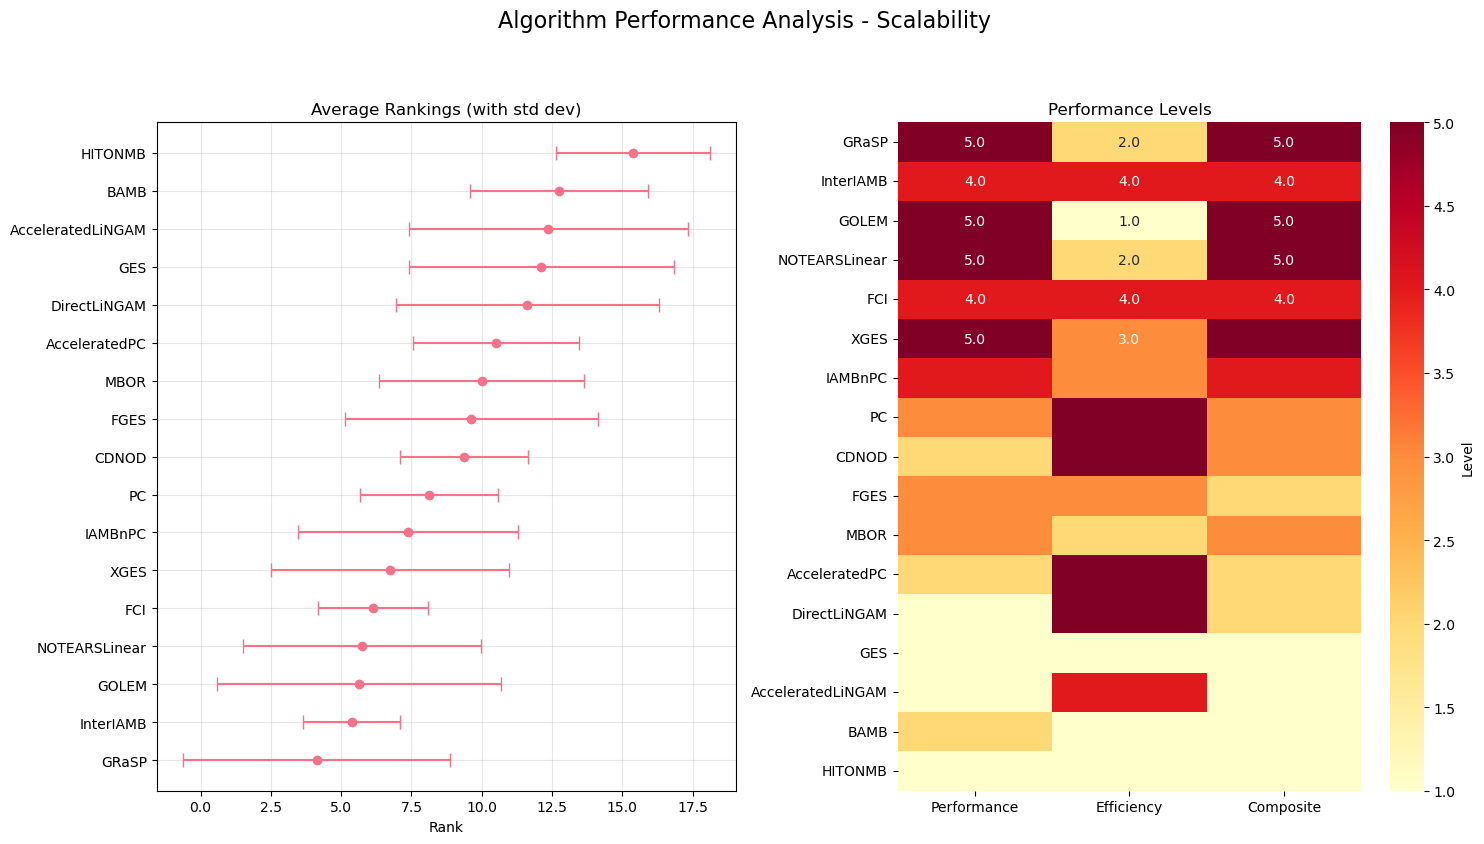

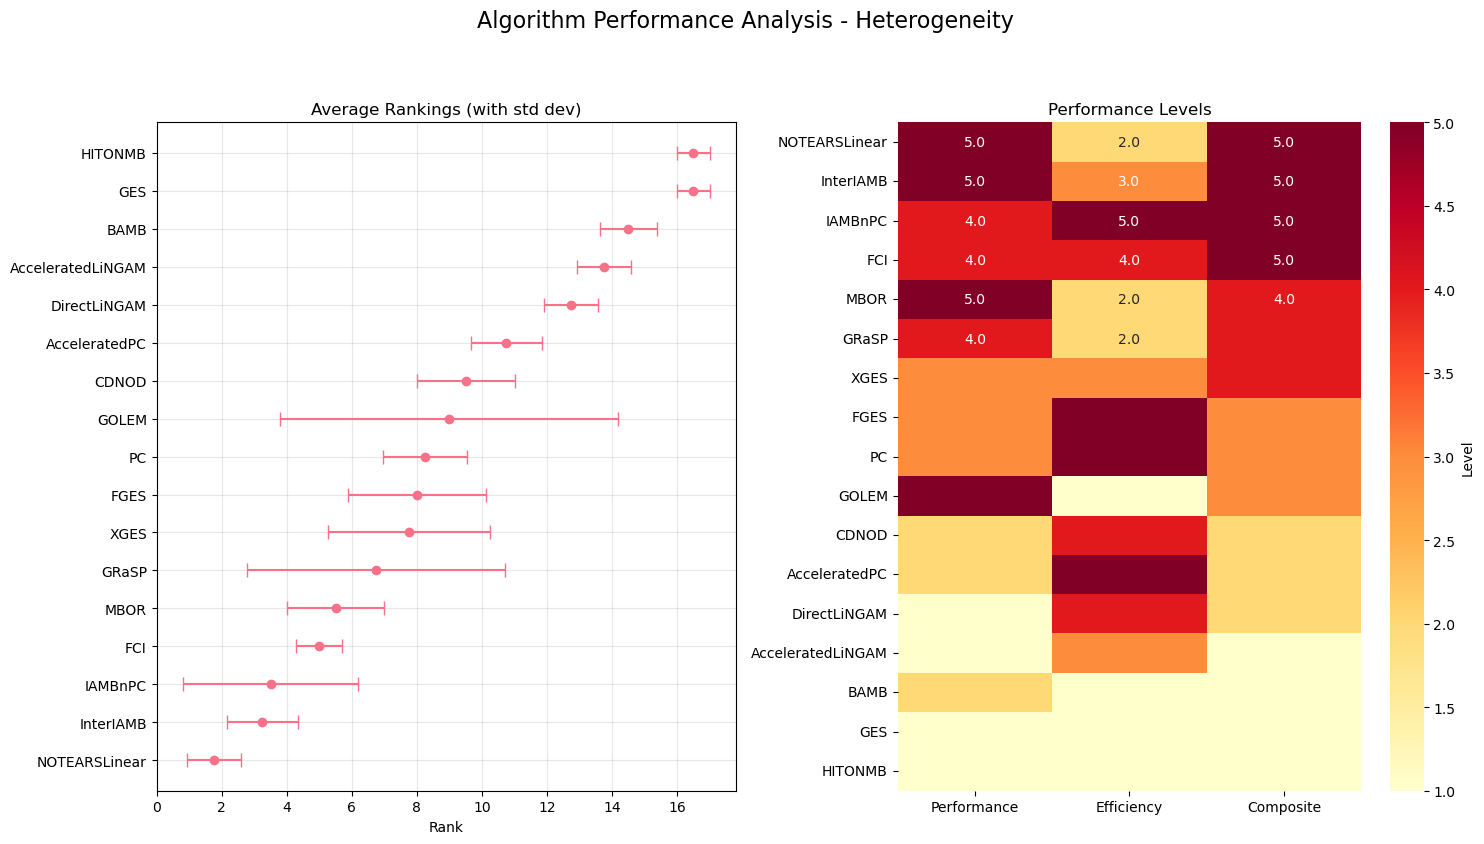

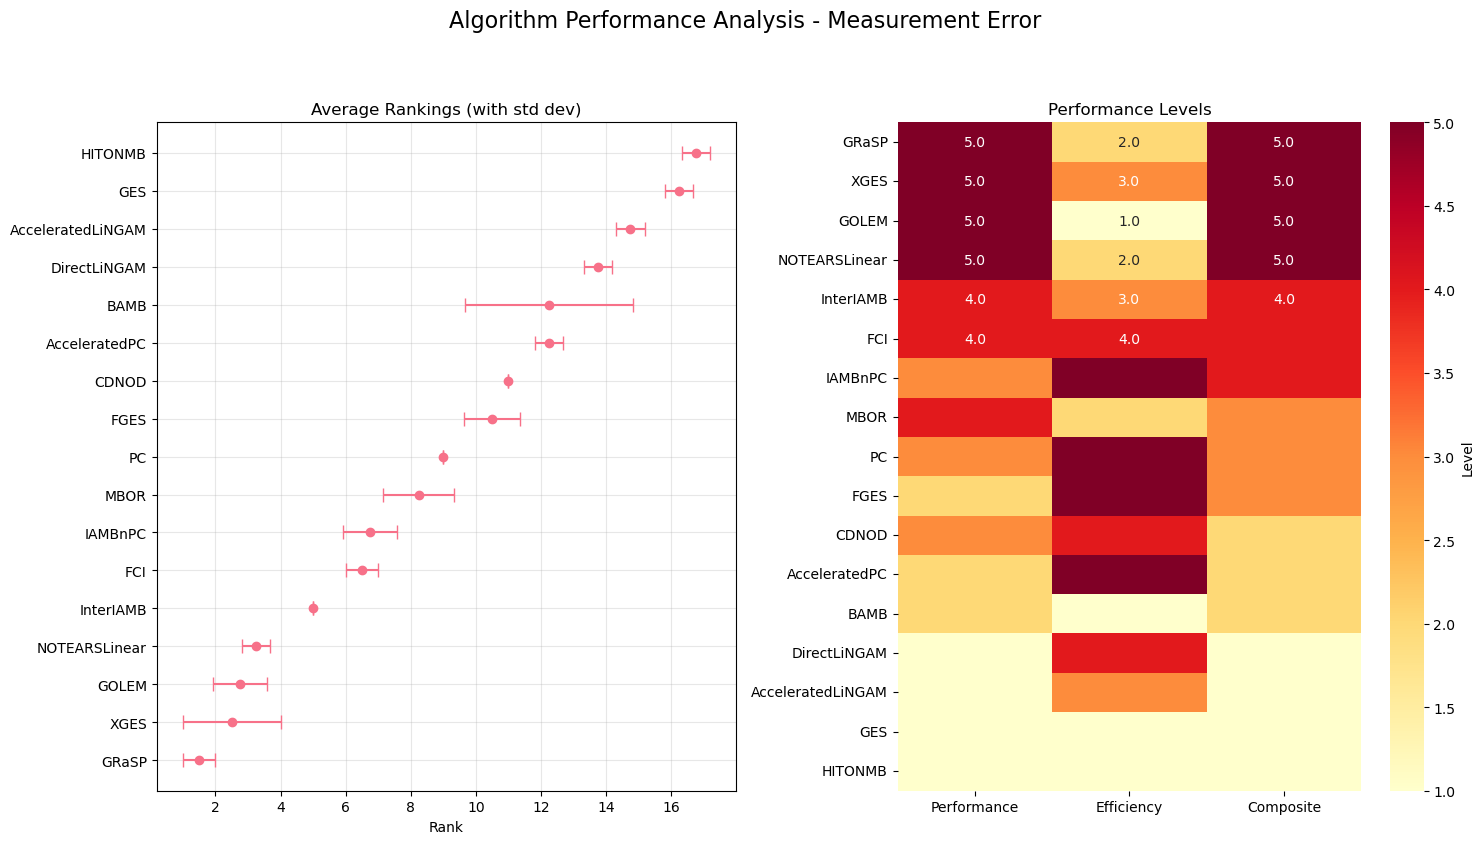

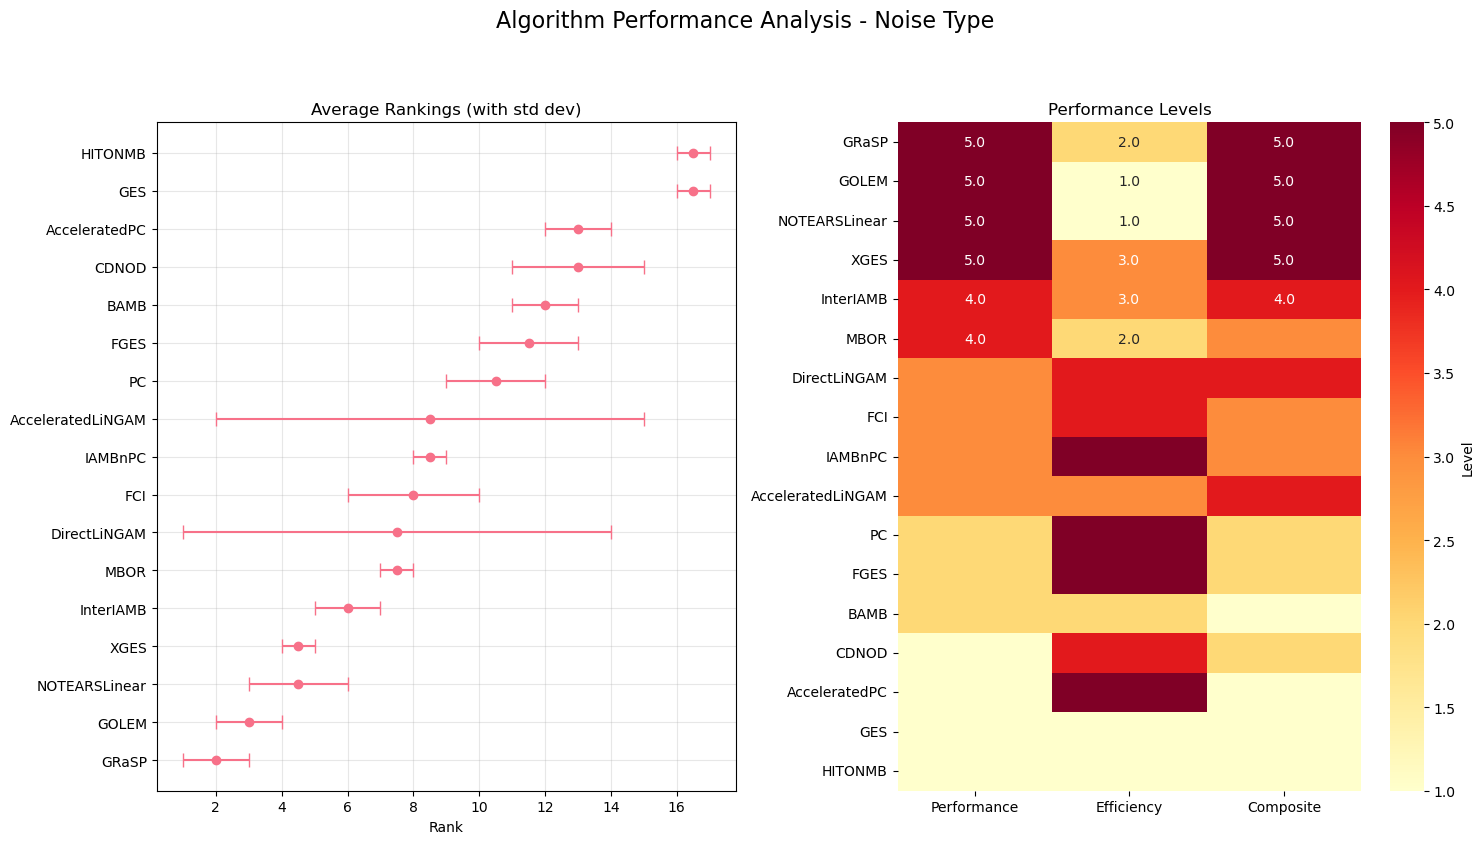

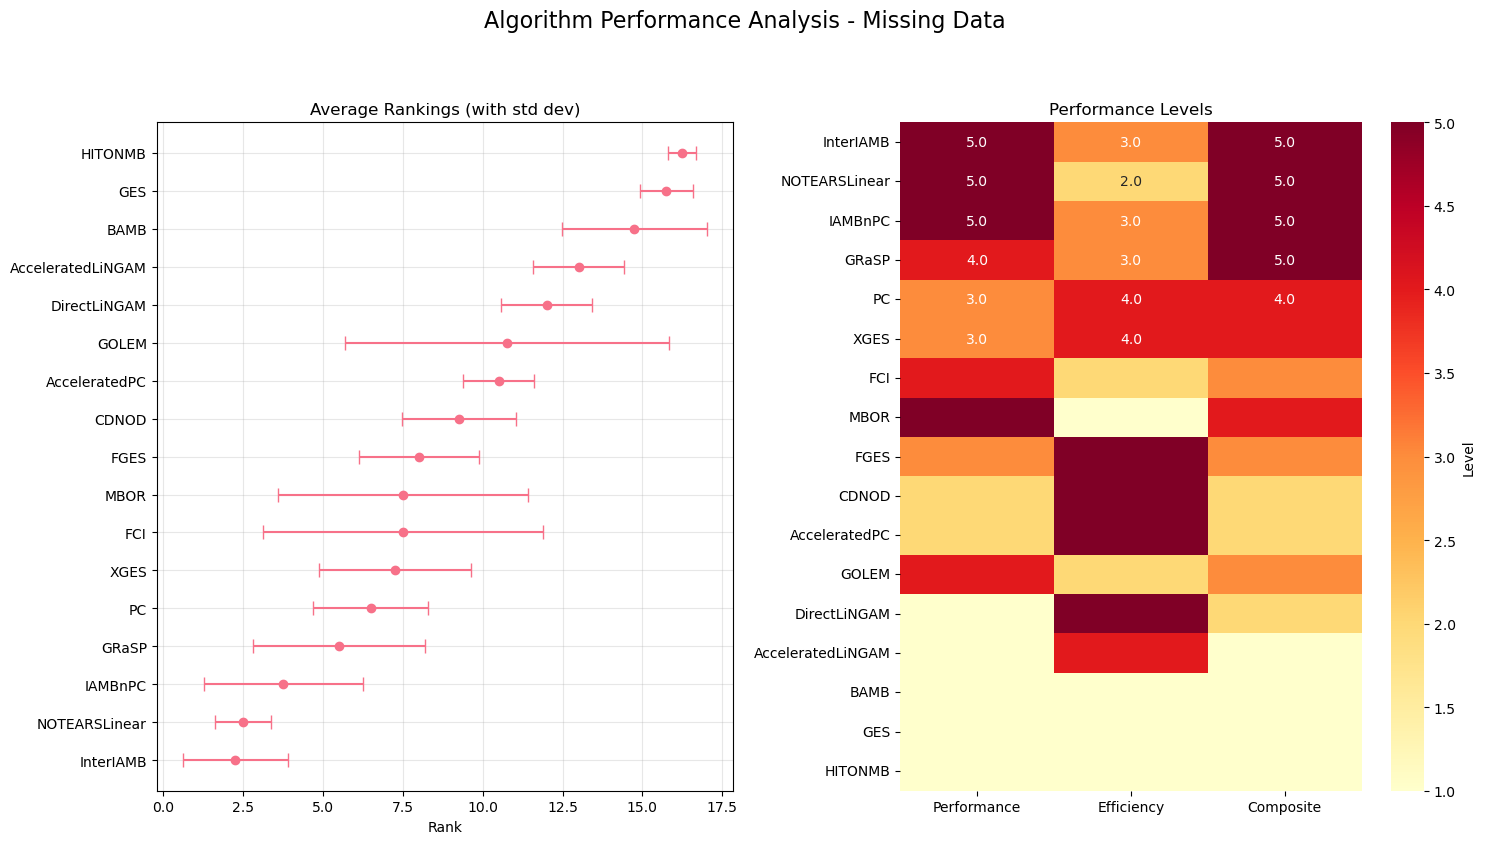

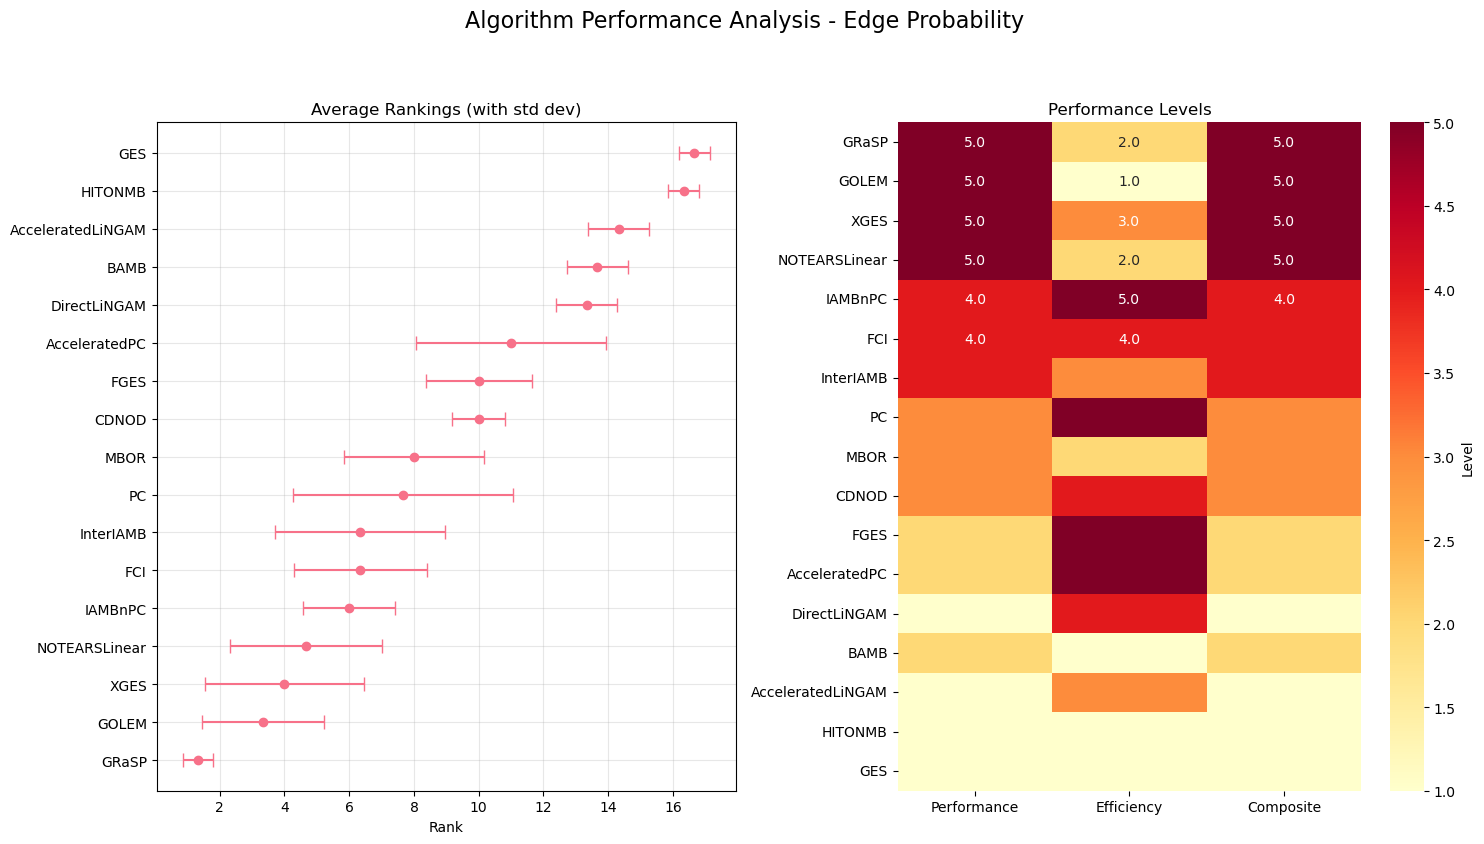

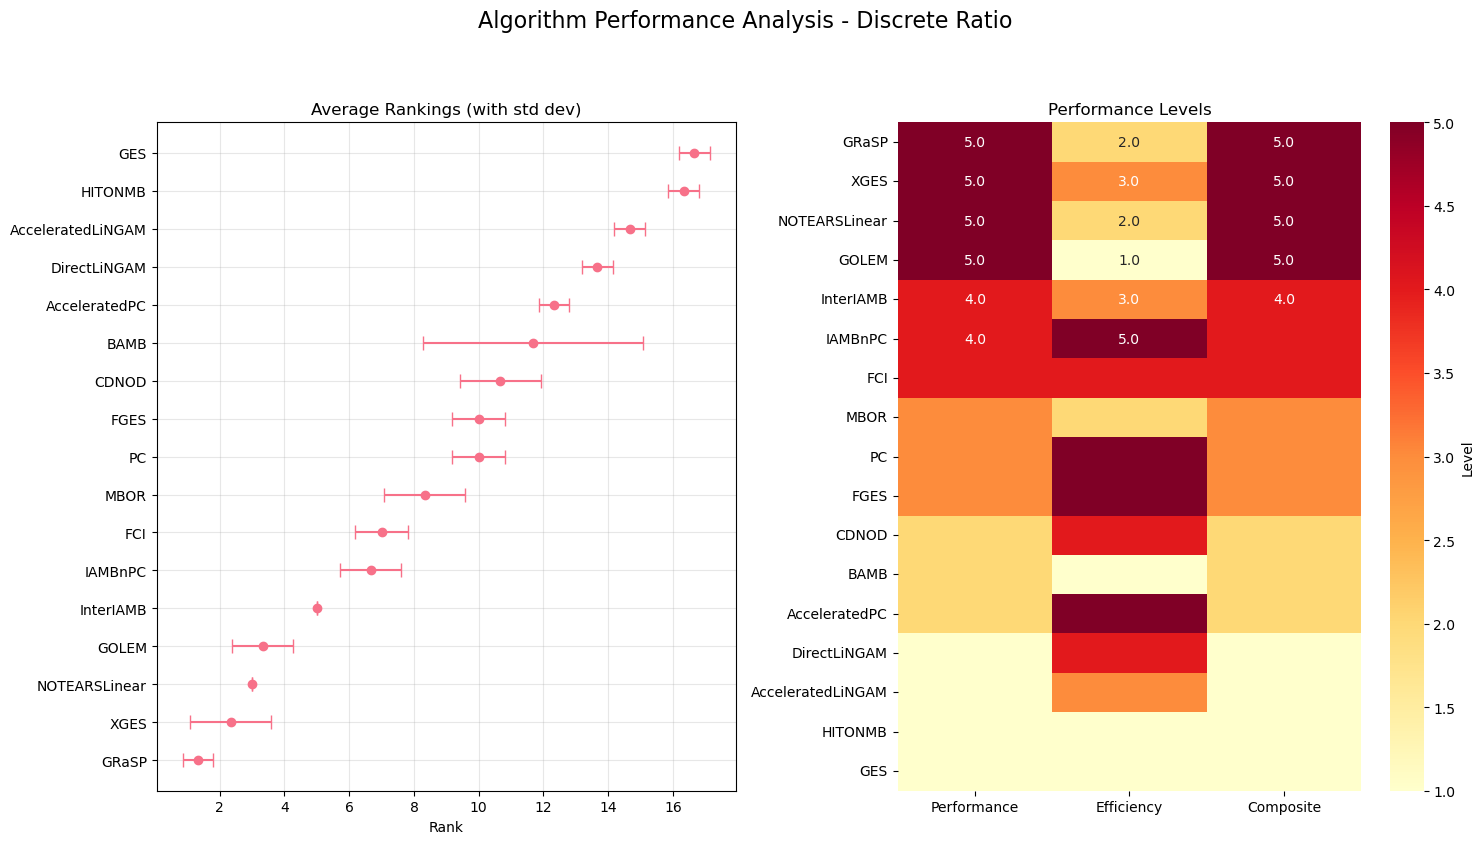


Results have been saved to: algorithm/context/benchmarking/algorithm_performance_results.json

Detailed Algorithm Performance for Scalability:
GRaSP:
  Ranking: 4.12 ± 4.75
  Performance Level: 5.0
  Efficiency Level: 2.0
  Composite Level: 5.0
InterIAMB:
  Ranking: 5.38 ± 1.73
  Performance Level: 4.0
  Efficiency Level: 4.0
  Composite Level: 4.0
GOLEM:
  Ranking: 5.62 ± 5.05
  Performance Level: 5.0
  Efficiency Level: 1.0
  Composite Level: 5.0
NOTEARSLinear:
  Ranking: 5.75 ± 4.24
  Performance Level: 5.0
  Efficiency Level: 2.0
  Composite Level: 5.0
FCI:
  Ranking: 6.12 ± 1.96
  Performance Level: 4.0
  Efficiency Level: 4.0
  Composite Level: 4.0
XGES:
  Ranking: 6.75 ± 4.24
  Performance Level: 5.0
  Efficiency Level: 3.0
  Composite Level: 5.0
IAMBnPC:
  Ranking: 7.38 ± 3.90
  Performance Level: 4.0
  Efficiency Level: 3.0
  Composite Level: 4.0
PC:
  Ranking: 8.12 ± 2.47
  Performance Level: 3.0
  Efficiency Level: 5.0
  Composite Level: 3.0
CDNOD:
  Ranking: 9.38 ± 2.29
  

In [16]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

N_LEVELS = 5
PERFORMANCE_RATIO = 0.7

def get_level(value, quantiles):
    """
    Get level (1-N_LEVELS) based on quantiles.
    """
    for i, q in enumerate(quantiles):
        if value <= q:
            return i + 1
    return N_LEVELS

def rank_and_level_algorithms_in_group(group_results, metric='metrics_f1', runtime_metric='runtime'):
    """
    Rank algorithms and assign levels based on quantiles of performance and efficiency scores.
    """
    performance = defaultdict(list)
    runtimes = defaultdict(list)
    for r in group_results:
        alg = r['algorithm']
        # Get the performance metric; if unsuccessful or invalid, assign 0.
        if r.get('success', False):
            try:
                score = float(r.get(metric, 0))
            except (ValueError, TypeError):
                score = 0
        else:
            score = 0
        performance[alg].append(score)
        
        # Get the runtime; if missing, default to a high runtime
        runtime_val = r.get(runtime_metric, 3600)
        runtimes[alg].append(runtime_val)
    
    # Compute mean performance and mean runtime for each algorithm
    avg_performance = {alg: np.mean(vals) for alg, vals in performance.items()}
    avg_runtime = {alg: np.mean(vals) for alg, vals in runtimes.items()}
    
    # Calculate efficiency scores
    sorted_runtimes = sorted(avg_runtime.values())
    # Drop the top 5% outliers
    cutoff_index = int(len(sorted_runtimes) * 0.95)
    filtered_runtimes = sorted_runtimes[:cutoff_index]
    worst_runtime = max(filtered_runtimes) if filtered_runtimes else 1
    efficiency_scores = {alg: 1 - (min(rt, worst_runtime) / worst_runtime) for alg, rt in avg_runtime.items()}
    
    # Calculate composite scores
    composite_scores = {}
    for alg in avg_performance:
        efficiency = efficiency_scores[alg]
        composite_scores[alg] = PERFORMANCE_RATIO * avg_performance[alg] + (1 - PERFORMANCE_RATIO) * efficiency
    
    # Calculate quantiles for performance, efficiency and composite scores
    perf_vals = list(avg_performance.values())
    eff_vals = list(efficiency_scores.values())
    comp_vals = list(composite_scores.values())
    
    percentiles = np.linspace(0, 100, N_LEVELS+1)[1:-1]  # Divide into N_LEVELS segments
    perf_quantiles = np.percentile(perf_vals, percentiles)
    eff_quantiles = np.percentile(eff_vals, percentiles)
    comp_quantiles = np.percentile(comp_vals, percentiles)
    
    # Assign levels
    performance_levels = {alg: get_level(score, perf_quantiles) for alg, score in avg_performance.items()}
    efficiency_levels = {alg: get_level(score, eff_quantiles) for alg, score in efficiency_scores.items()}
    composite_levels = {alg: get_level(score, comp_quantiles) for alg, score in composite_scores.items()}
    
    # Rank algorithms
    sorted_algs = sorted(composite_scores.items(), key=lambda x: x[1], reverse=True)
    ranking = {alg: rank for rank, (alg, _) in enumerate(sorted_algs, start=1)}
    
    return ranking, avg_performance, efficiency_scores, composite_scores

def compute_average_ranking_and_levels(groups, metric='metrics_f1', runtime_metric='runtime'):
    """
    Compute average rankings and levels across groups.
    """
    alg_ranks = defaultdict(list)
    alg_perf_scores = defaultdict(list)
    alg_eff_scores = defaultdict(list)
    alg_comp_scores = defaultdict(list)
    
    for group_label, group_results in groups.items():
        ranking, perf_scores, eff_scores, comp_scores = rank_and_level_algorithms_in_group(
            group_results, metric, runtime_metric)
        
        for alg in ranking:
            alg_ranks[alg].append(ranking[alg])
            alg_perf_scores[alg].append(perf_scores[alg])
            alg_eff_scores[alg].append(eff_scores[alg])
            alg_comp_scores[alg].append(comp_scores[alg])
    
    avg_rank = {alg: np.mean(ranks) for alg, ranks in alg_ranks.items()}
    std_rank = {alg: np.std(ranks) for alg, ranks in alg_ranks.items()}
    
    # Calculate average scores first
    avg_perf_scores = {alg: np.mean(scores) for alg, scores in alg_perf_scores.items()}
    avg_eff_scores = {alg: np.mean(scores) for alg, scores in alg_eff_scores.items()}
    avg_comp_scores = {alg: np.mean(scores) for alg, scores in alg_comp_scores.items()}
    
    # Calculate quantiles from average scores
    perf_quantiles = np.percentile(list(avg_perf_scores.values()), np.linspace(0, 100, N_LEVELS+1)[1:-1])
    eff_quantiles = np.percentile(list(avg_eff_scores.values()), np.linspace(0, 100, N_LEVELS+1)[1:-1])
    comp_quantiles = np.percentile(list(avg_comp_scores.values()), np.linspace(0, 100, N_LEVELS+1)[1:-1])
    
    # Assign levels based on average scores
    avg_perf_level = {alg: get_level(score, perf_quantiles) for alg, score in avg_perf_scores.items()}
    avg_eff_level = {alg: get_level(score, eff_quantiles) for alg, score in avg_eff_scores.items()}
    avg_comp_level = {alg: get_level(score, comp_quantiles) for alg, score in avg_comp_scores.items()}
    
    return avg_rank, std_rank, avg_perf_level, avg_eff_level, avg_comp_level

results = load_results('simulated_data/algorithm_benchmarking_results_v2/20250207_114523')

# Define function keys for each configuration type
scaling_configs = {
    'Scale 25000 (5x5000)': {'data_config_n_nodes': 5, 'data_config_n_samples': 5000},
    'Scale 25000 (25x1000)': {'data_config_n_nodes': 25, 'data_config_n_samples': 1000},
    'Scale 50000 (10x5000)': {'data_config_n_nodes': 10, 'data_config_n_samples': 5000},
    'Scale 62500 (25x2500)': {'data_config_n_nodes': 25, 'data_config_n_samples': 2500},
    'Scale 125000 (25x5000)': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000},
    'Scale 250000 (50x5000)': {'data_config_n_nodes': 50, 'data_config_n_samples': 5000},
    'Scale 250000 (25x10000)': {'data_config_n_nodes': 25, 'data_config_n_samples': 10000},
    'Scale 500000 (100x5000)': {'data_config_n_nodes': 100, 'data_config_n_samples': 5000},
}

heterogeneous_configs = {
    'Homogeneous': {'data_config_n_domains': 1},
    'Heterogeneous (2 domains)': {'data_config_n_domains': 2},
    'Heterogeneous (5 domains)': {'data_config_n_domains': 5},
    'Heterogeneous (10 domains)': {'data_config_n_domains': 10}
}

measurement_error_configs = {
    'Clean': {'data_config_measurement_error': None},
    'ME 10%': {'data_config_measurement_error': '0.1'},
    'ME 30%': {'data_config_measurement_error': '0.3'},
    'ME 50%': {'data_config_measurement_error': '0.5'}
}

noise_configs = {
    'Gaussian': {'data_config_noise_type': 'gaussian'},
    'Uniform': {'data_config_noise_type': 'uniform'}
}

missing_configs = {
    'No Missing': {'data_config_missing_rate': None},
    'Missing 10%': {'data_config_missing_rate': '0.1'},
    'Missing 20%': {'data_config_missing_rate': '0.2'},
    'Missing 30%': {'data_config_missing_rate': '0.3'}
}

edge_prob_configs = {
    'Edge Prob 10%': {'data_config_edge_probability': 0.1},
    'Edge Prob 20%': {'data_config_edge_probability': 0.2},
    'Edge Prob 30%': {'data_config_edge_probability': 0.3}
}

discrete_ratio_configs = {
    'No Discrete Data': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.0},
    'Discrete Data Ratio 0.1': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.1},
    'Discrete Data Ratio 0.2': {'data_config_n_nodes': 25, 'data_config_n_samples': 5000, 'data_config_discrete_ratio': 0.2}
}

# Group results using filter_results
scaling_groups = {label: filter_results(results, **config) for label, config in scaling_configs.items()}
heterogeneous_groups = {label: filter_results(results, **config) for label, config in heterogeneous_configs.items()}
me_groups = {label: filter_results(results, **config) for label, config in measurement_error_configs.items()}
noise_groups = {label: filter_results(results, **config) for label, config in noise_configs.items()}
missing_groups = {label: filter_results(results, **config) for label, config in missing_configs.items()}
edge_prob_groups = {label: filter_results(results, **config) for label, config in edge_prob_configs.items()}
discrete_ratio_groups = {label: filter_results(results, **config) for label, config in discrete_ratio_configs.items()}

# Initialize dictionary to store all results
all_results = {}

# Compute rankings and levels for each configuration type
metrics = [
    ('Scalability', scaling_groups),
    ('Heterogeneity', heterogeneous_groups),
    ('Measurement Error', me_groups),
    ('Noise Type', noise_groups),
    ('Missing Data', missing_groups),
    ('Edge Probability', edge_prob_groups),
    ('Discrete Ratio', discrete_ratio_groups)
]

for category_name, groups in metrics:
    avg_rank, std_rank, avg_perf_level, avg_eff_level, avg_comp_level = compute_average_ranking_and_levels(groups)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f'Algorithm Performance Analysis - {category_name}', fontsize=16, y=1.05)
    
    # Sort algorithms by average rank
    algorithms = sorted(avg_rank.keys(), key=lambda x: avg_rank[x])
    
    # Rankings plot
    ranks = [avg_rank[alg] for alg in algorithms]
    errors = [std_rank[alg] for alg in algorithms]
    
    ax1.errorbar(ranks, algorithms, xerr=errors, fmt='o', capsize=5)
    ax1.set_title('Average Rankings (with std dev)')
    ax1.set_xlabel('Rank')
    ax1.grid(True, alpha=0.3)
    
    # Levels plot
    levels_data = {
        'Performance': [avg_perf_level[alg] for alg in algorithms],
        'Efficiency': [avg_eff_level[alg] for alg in algorithms],
        'Composite': [avg_comp_level[alg] for alg in algorithms]
    }
    
    df = pd.DataFrame(levels_data, index=algorithms)
    sns.heatmap(df, annot=True, cmap='YlOrRd', ax=ax2, fmt='.1f', 
                cbar_kws={'label': 'Level'})
    ax2.set_title('Performance Levels')
    
    plt.tight_layout()
    plt.show()
    
    # Store results for this category
    category_results = {}
    for alg in algorithms:
        category_results[alg] = {
            "ranking": {
                "mean": float(avg_rank[alg]),
                "std": float(std_rank[alg])
            },
            "levels": {
                "performance": float(avg_perf_level[alg]),
                "efficiency": float(avg_eff_level[alg]),
                "composite": float(avg_comp_level[alg])
            }
        }
    all_results[category_name] = category_results

# Save all results to a single JSON file
output_file = "algorithm/context/benchmarking/algorithm_performance_results.json"
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

# Print summary to console
print("\nResults have been saved to:", output_file)
for category_name in all_results:
    print(f"\nDetailed Algorithm Performance for {category_name}:")
    for alg in all_results[category_name]:
        results = all_results[category_name][alg]
        print(f"{alg}:")
        print(f"  Ranking: {results['ranking']['mean']:.2f} ± {results['ranking']['std']:.2f}")
        print(f"  Performance Level: {results['levels']['performance']:.1f}")
        print(f"  Efficiency Level: {results['levels']['efficiency']:.1f}")
        print(f"  Composite Level: {results['levels']['composite']:.1f}")


## Time cost of using Non-linear hyperparameters

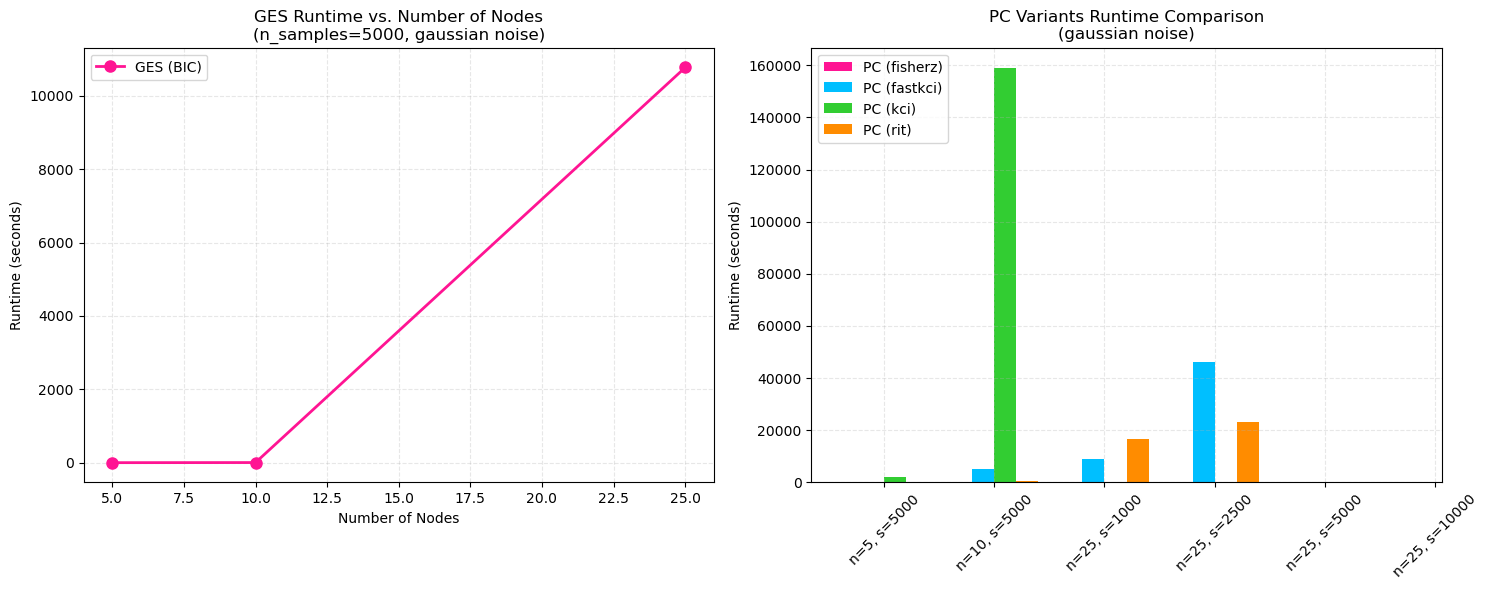

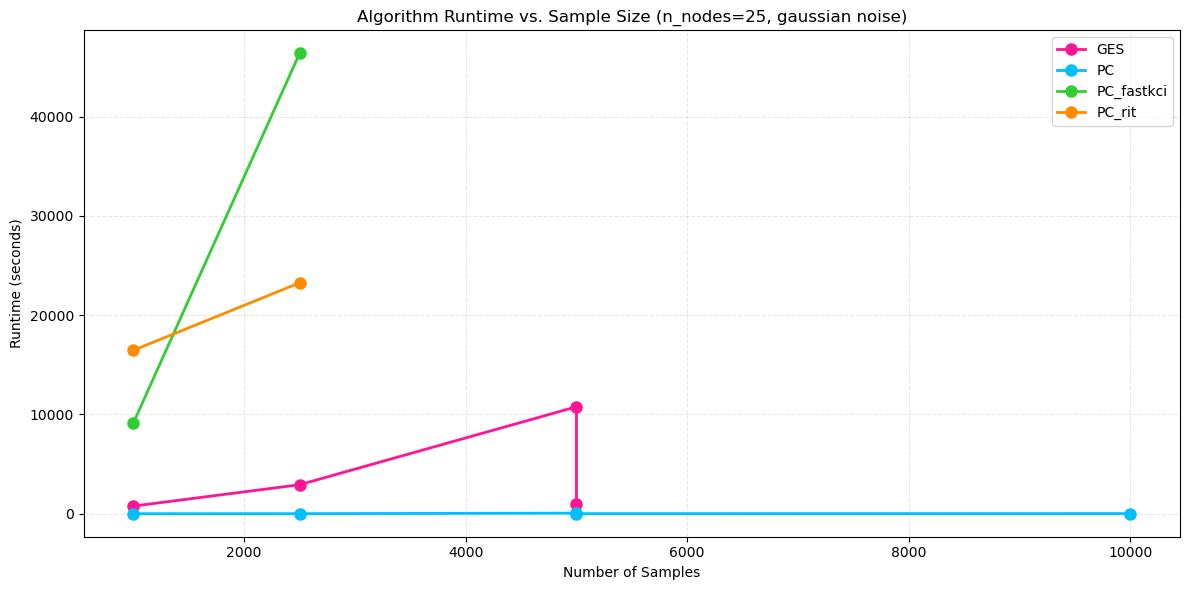

Runtime ratios compared to base methods:

PC variants vs PC (fisherz):
n_nodes=5, n_samples=5000, noise=gaussian:
  PC_fastkci is 5624.9x slower than PC (fisherz)
  PC_kci is 66348.7x slower than PC (fisherz)
  PC_rit is 203.7x slower than PC (fisherz)
n_nodes=10, n_samples=5000, noise=gaussian:
  PC_fastkci is 30742.1x slower than PC (fisherz)
  PC_kci is 940586.0x slower than PC (fisherz)
  PC_rit is 2704.7x slower than PC (fisherz)
n_nodes=25, n_samples=1000, noise=gaussian:
  PC_fastkci is 1183.9x slower than PC (fisherz)
  PC_rit is 2126.0x slower than PC (fisherz)
n_nodes=25, n_samples=2500, noise=gaussian:
  PC_fastkci is 3843.7x slower than PC (fisherz)
  PC_rit is 1928.1x slower than PC (fisherz)
n_nodes=25, n_samples=5000, noise=gaussian:
n_nodes=25, n_samples=5000, noise=uniform:
n_nodes=25, n_samples=10000, noise=gaussian:
n_nodes=50, n_samples=5000, noise=gaussian:
n_nodes=100, n_samples=5000, noise=gaussian:

GES vs PC (fisherz) for comparable settings:
n_nodes=5, n_sampl

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame from the provided data
data = [
    [5, 5000, "gaussian", 0.19579458236694336, 0.029850880304972332, 167.9092648824056, 1980.56574122111, 6.08102011680603],
    [10, 5000, "gaussian", 3.0456265608469644, 0.1688086986541748, 5189.537152290344, 158779.0911204815, 456.5750036239624],
    [25, 1000, "gaussian", 775.7833743890127, 7.745217323303223, 9169.197857260704, np.nan, 16466.20217402776],
    [25, 2500, "gaussian", 2926.153843720754, 12.062713384628296, 46365.59056699276, np.nan, 23257.964894215267],
    [25, 5000, "gaussian", 10776.333441921643, 64.33404930432637, np.nan, np.nan, np.nan],
    [25, 5000, "uniform", 985.5654017925262, 15.425962845484415, np.nan, np.nan, np.nan],
    [25, 10000, "gaussian", np.nan, 18.521164973576862, np.nan, np.nan, np.nan],
    [50, 5000, "gaussian", np.nan, 200.09898853302002, np.nan, np.nan, np.nan],
    [100, 5000, "gaussian", np.nan, 2293.7035369078317, np.nan, np.nan, np.nan]
]

columns = ["n_nodes", "n_samples", "noise_type", "GES", "PC", "PC_fastkci", "PC_kci", "PC_rit"]
df = pd.DataFrame(data, columns=columns)

# Define a high contrast color palette
colors = ['#FF1493', '#00BFFF', '#32CD32', '#FF8C00', '#9932CC']  # Hot pink, Deep sky blue, Lime green, Dark orange, Dark orchid

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Compare GES (BIC) with other methods
# Filter data for n_samples=5000 and gaussian noise
ges_data = df[(df['n_samples'] == 5000) & (df['noise_type'] == 'gaussian')].copy()
ges_data = ges_data.set_index('n_nodes')
ges_cols = ['GES']

# Plot GES runtime vs nodes
ax1.plot(ges_data.index, ges_data['GES'], 'o-', linewidth=2, markersize=8, label='GES (BIC)', color=colors[0])
ax1.set_xlabel('Number of Nodes')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('GES Runtime vs. Number of Nodes\n(n_samples=5000, gaussian noise)')
ax1.grid(True, which="both", ls="--", alpha=0.3)
ax1.legend()

# Plot 2: Compare PC (fisherz) with other PC variants
# Filter data for n_nodes=25 and gaussian noise for different sample sizes
pc_data = df[(df['n_nodes'].isin([5, 10, 25])) & (df['noise_type'] == 'gaussian')].copy()

# Create a grouped bar chart
pc_methods = ['PC', 'PC_fastkci', 'PC_kci', 'PC_rit']
pc_labels = ['PC (fisherz)', 'PC (fastkci)', 'PC (kci)', 'PC (rit)']

# Set up the positions for the bars
bar_width = 0.2
positions = np.arange(len(pc_data))

# Plot each PC variant
for i, (method, label) in enumerate(zip(pc_methods, pc_labels)):
    # Skip if all values are NaN
    if not pc_data[method].isna().all():
        ax2.bar(positions + i*bar_width - bar_width*1.5, pc_data[method], 
                width=bar_width, label=label, color=colors[i % len(colors)])

# Set the x-axis labels to show node and sample size
x_labels = [f"n={row['n_nodes']}, s={row['n_samples']}" for _, row in pc_data.iterrows()]
ax2.set_xticks(positions)
ax2.set_xticklabels(x_labels, rotation=45)
ax2.set_ylabel('Runtime (seconds)')
ax2.set_title('PC Variants Runtime Comparison\n(gaussian noise)')
ax2.grid(True, which="both", ls="--", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Create a more detailed comparison for n_nodes=25
n25_data = df[df['n_nodes'] == 25].copy()
if not n25_data.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot runtime vs sample size for n_nodes=25
    for i, method in enumerate(['GES', 'PC', 'PC_fastkci', 'PC_rit']):
        valid_data = n25_data[['n_samples', method]].dropna()
        if not valid_data.empty:
            plt.plot(valid_data['n_samples'], valid_data[method], 'o-', 
                    linewidth=2, markersize=8, label=method, color=colors[i % len(colors)])
    
    plt.xscale('linear')
    plt.xlabel('Number of Samples')
    plt.ylabel('Runtime (seconds)')
    plt.title('Algorithm Runtime vs. Sample Size (n_nodes=25, gaussian noise)')
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create a table to show the runtime ratios
print("Runtime ratios compared to base methods:")
print("\nPC variants vs PC (fisherz):")
for idx, row in df.iterrows():
    if not pd.isna(row['PC']):
        print(f"n_nodes={row['n_nodes']}, n_samples={row['n_samples']}, noise={row['noise_type']}:")
        for method in ['PC_fastkci', 'PC_kci', 'PC_rit']:
            if not pd.isna(row[method]):
                ratio = row[method] / row['PC']
                print(f"  {method} is {ratio:.1f}x slower than PC (fisherz)")

print("\nGES vs PC (fisherz) for comparable settings:")
for idx, row in df.iterrows():
    if not pd.isna(row['GES']) and not pd.isna(row['PC']):
        ratio = row['GES'] / row['PC']
        print(f"n_nodes={row['n_nodes']}, n_samples={row['n_samples']}, noise={row['noise_type']}: GES is {ratio:.1f}x slower than PC")


In [3]:
!ls

Gradio           data             output           setup
README.md        dataset          plot.ipynb       simulated_data
__pycache__      demo_data        postprocess      tiny_copilot.py
algorithm        externals        preprocess       user
asset            global_setting   report
causal_analysis  main.py          requirements.txt


['simulated_data/copilot_evaluation_results/20250325_141023/nodes10_samples500_domains1_noisegaussian_funclinear_edgeprob0.2_discrete0.0_seed0_results.json', 'simulated_data/copilot_evaluation_results/20250325_141023/nodes10_samples500_domains1_noisegaussian_funclinear_edgeprob0.2_discrete0.2_seed2_results.json', 'simulated_data/copilot_evaluation_results/20250325_141023/nodes10_samples500_domains1_noiseuniform_funclinear_edgeprob0.2_discrete0.0_seed1_results.json', 'simulated_data/copilot_evaluation_results/20250325_141023/nodes5_samples500_domains1_noisegaussian_funclinear_edgeprob0.2_discrete0.0_seed0_results.json', 'simulated_data/copilot_evaluation_results/20250325_141023/nodes10_samples500_domains1_noisegaussian_funclinear_edgeprob0.2_discrete0.0_missing0.1_seed2_results.json', 'simulated_data/copilot_evaluation_results/20250325_141023/nodes10_samples500_domains1_noisegaussian_funcmlp_edgeprob0.2_discrete0.0_seed2_results.json', 'simulated_data/copilot_evaluation_results/20250325

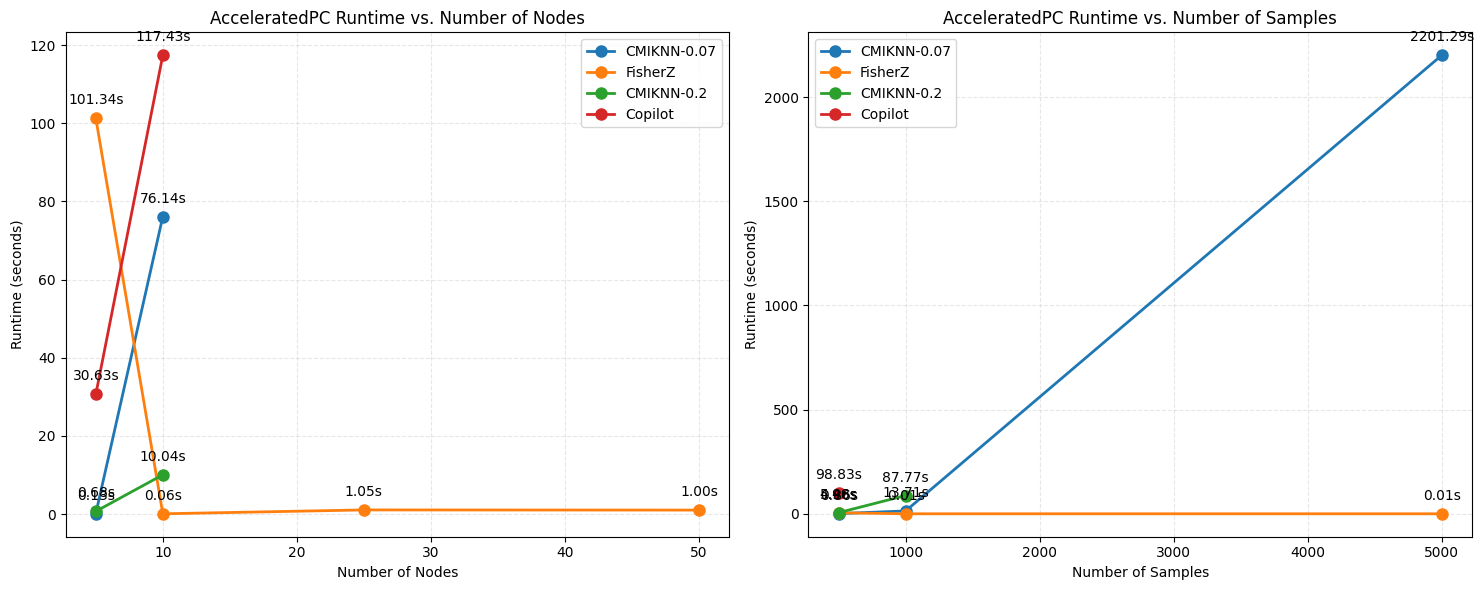

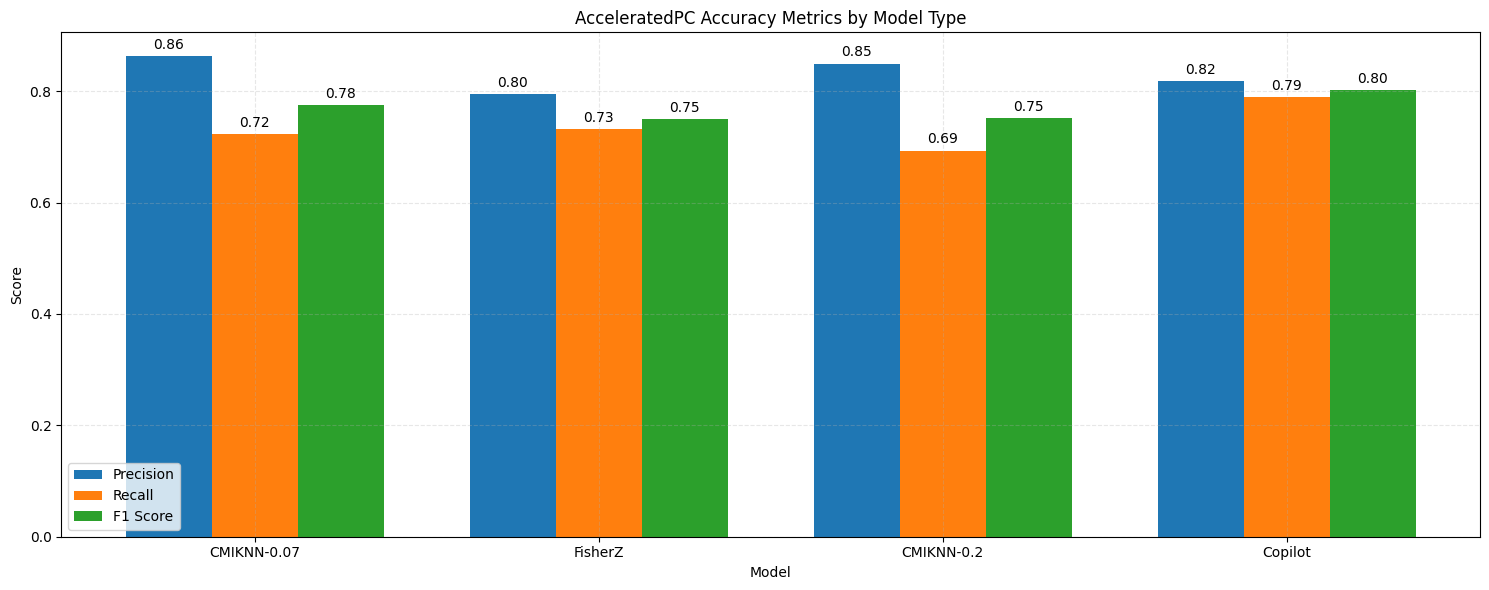

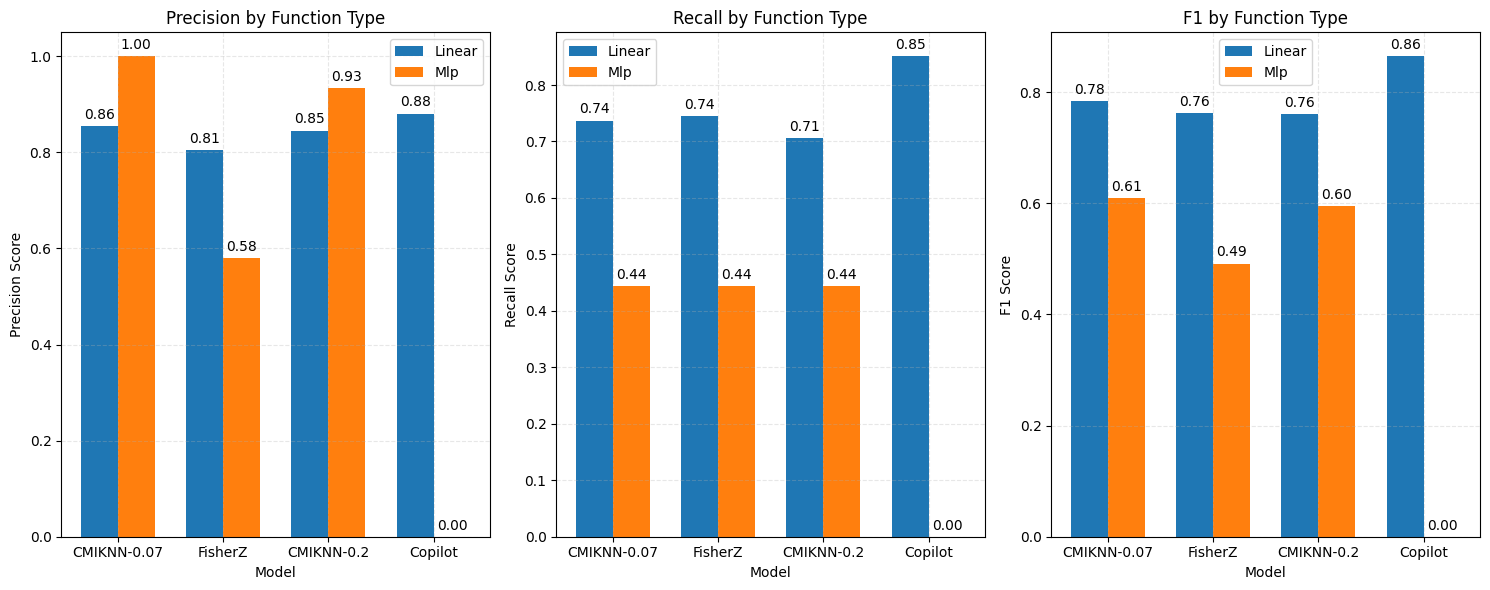

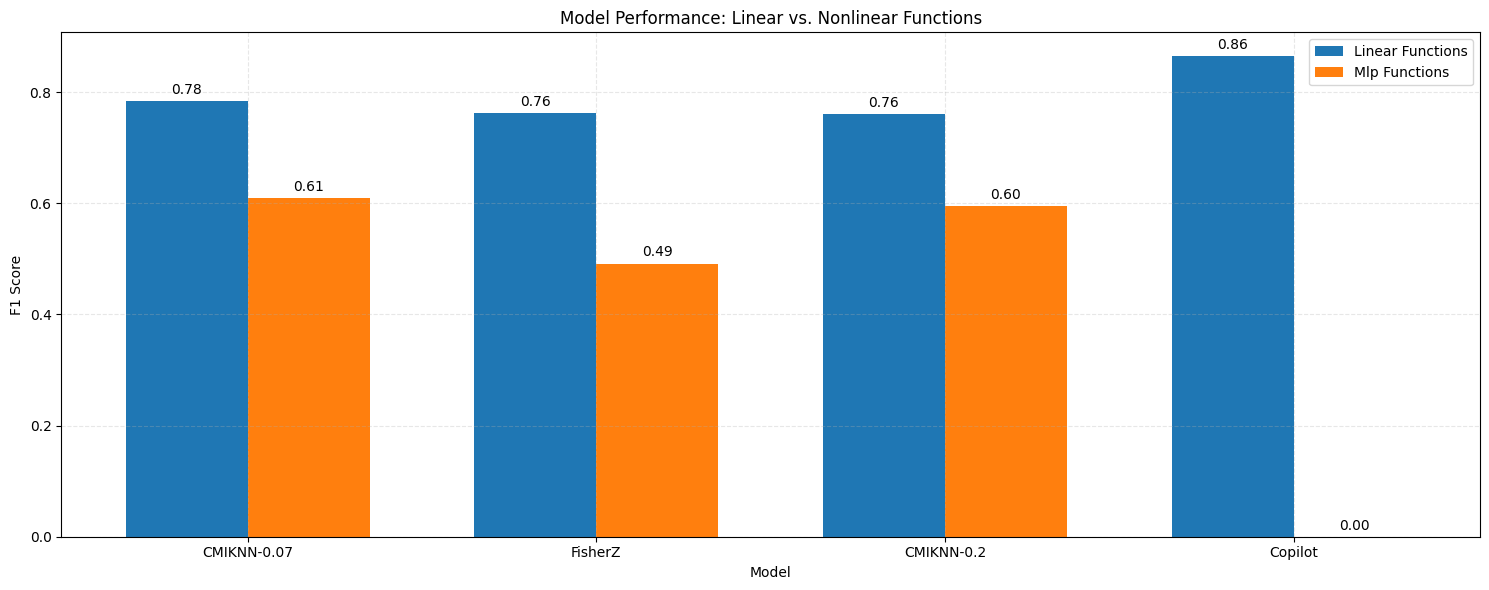

In [12]:
# Compare AcceleratedPC results from different benchmark runs
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Define the benchmark directories and their corresponding model names
model_names = [
    "CMIKNN-0.07",
    "FisherZ",
    "CMIKNN-0.2",
    "Copilot"
]

benchmark_dirs = [
    "simulated_data/algorithm_benchmarking_results_cmiknn/20250325_033900",
    "simulated_data/algorithm_benchmarking_results_cmiknn/20250325_035416",
    "simulated_data/algorithm_benchmarking_results_cmiknn/20250325_040847",
    "simulated_data/copilot_evaluation_results/20250325_141023"
]

# Function to load and process benchmark data
def load_benchmark_data(directory, algorithm="AcceleratedPC"):
    # Special handling for Copilot data which has a different structure
    if "copilot_evaluation_results" in directory:
        # Find all experiment subdirectories
        result_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json')]
        print(result_files)
        
        processed_data = []
        for result_file in result_files:
            with open(os.path.join(result_file), 'r') as f:
                data = json.load(f)
            
            for entry in data:
                if entry["success"]:
                    processed_data.append({
                        "n_nodes": entry["data_config"]["n_nodes"],
                        "n_samples": entry["data_config"]["n_samples"],
                        "noise_type": entry["data_config"]["noise_type"],
                        "function_type": entry["data_config"]["function_type"],
                        "seed": entry["data_config"]["seed"],
                        "runtime": float(entry["runtime"]),
                        "precision": float(entry["metrics"]["precision"]),
                        "recall": float(entry["metrics"]["recall"]),
                        "f1": float(entry["metrics"]["f1"]),
                        "shd": float(entry["metrics"]["shd"]),
                    })
        
        return processed_data
    else:
        # Original handling for AcceleratedPC data
        results_file = os.path.join(directory, f"{algorithm}_results.json")
        if not os.path.exists(results_file):
            print(f"Warning: {results_file} not found")
            return None
        
        with open(results_file, 'r') as f:
            data = json.load(f)
        
        processed_data = []
        for entry in data:
            if entry["success"]:
                processed_data.append({
                    "n_nodes": entry["data_config"]["n_nodes"],
                    "n_samples": entry["data_config"]["n_samples"],
                    "noise_type": entry["data_config"]["noise_type"],
                    "function_type": entry["data_config"]["function_type"],
                    "seed": entry["data_config"]["seed"],
                    "runtime": entry["runtime"],
                    "precision": entry["metrics"]["precision"],
                    "recall": entry["metrics"]["recall"],
                    "f1": entry["metrics"]["f1"],
                    "shd": float(entry["metrics"]["shd"]),
                    "benchmark_id": os.path.basename(directory)
                })
        
        return processed_data

# Load data from all benchmark directories with model names
all_data = []
for i, directory in enumerate(benchmark_dirs):
    data = load_benchmark_data(directory)
    if data:
        # Add model name to each entry
        for entry in data:
            entry["model_name"] = model_names[i]
        all_data.extend(data)

# Convert to DataFrame
df_benchmarks = pd.DataFrame(all_data)

if not df_benchmarks.empty:
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot runtime vs n_nodes for different models
    for i, model in enumerate(model_names):
        model_data = df_benchmarks[df_benchmarks['model_name'] == model]
        if not model_data.empty:
            # Group by n_nodes and calculate mean runtime
            runtime_by_nodes = model_data.groupby('n_nodes')['runtime'].mean().reset_index()
            line = ax1.plot(runtime_by_nodes['n_nodes'], runtime_by_nodes['runtime'], 'o-', 
                    linewidth=2, markersize=8, label=model)
            
            # Add data point values
            for x, y in zip(runtime_by_nodes['n_nodes'], runtime_by_nodes['runtime']):
                ax1.annotate(f'{y:.2f}s', 
                            (x, y),
                            textcoords="offset points", 
                            xytext=(0, 10), 
                            ha='center')
    
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_title('AcceleratedPC Runtime vs. Number of Nodes')
    ax1.grid(True, which="both", ls="--", alpha=0.3)
    ax1.legend()
    
    # Plot runtime vs n_samples for different models
    for i, model in enumerate(model_names):
        model_data = df_benchmarks[df_benchmarks['model_name'] == model]
        if not model_data.empty:
            # Group by n_samples and calculate mean runtime
            runtime_by_samples = model_data.groupby('n_samples')['runtime'].mean().reset_index()
            line = ax2.plot(runtime_by_samples['n_samples'], runtime_by_samples['runtime'], 'o-', 
                    linewidth=2, markersize=8, label=model)
            
            # Add data point values
            for x, y in zip(runtime_by_samples['n_samples'], runtime_by_samples['runtime']):
                ax2.annotate(f'{y:.2f}s', 
                            (x, y),
                            textcoords="offset points", 
                            xytext=(0, 10), 
                            ha='center')
    
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_title('AcceleratedPC Runtime vs. Number of Samples')
    ax2.grid(True, which="both", ls="--", alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a figure to compare accuracy metrics across models
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Calculate mean accuracy metrics for each model
    metrics_by_model = df_benchmarks.groupby('model_name').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'runtime': 'mean'
    }).reset_index()
    
    # Create bar chart for precision, recall, and F1
    bar_width = 0.25
    x = np.arange(len(model_names))
    
    # Ensure metrics_by_model is in the same order as model_names
    metrics_by_model = metrics_by_model.set_index('model_name').loc[model_names].reset_index()
    
    # Create bars and add value labels
    precision_bars = plt.bar(x - bar_width, metrics_by_model['precision'], bar_width, label='Precision')
    recall_bars = plt.bar(x, metrics_by_model['recall'], bar_width, label='Recall')
    f1_bars = plt.bar(x + bar_width, metrics_by_model['f1'], bar_width, label='F1 Score')
    
    # Add value labels on top of each bar
    for bars in [precision_bars, recall_bars, f1_bars]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('AcceleratedPC Accuracy Metrics by Model Type')
    plt.xticks(x, metrics_by_model['model_name'])
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compare performance between linear and nonlinear function types
    if 'function_type' in df_benchmarks.columns and len(df_benchmarks['function_type'].unique()) > 1:
        # Create a figure with three subplots for comparing linear vs nonlinear
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        
        # Metrics to compare
        metrics = ['precision', 'recall', 'f1']
        
        # Group by model_name and function_type
        grouped_metrics = df_benchmarks.groupby(['model_name', 'function_type']).agg({
            'precision': 'mean',
            'recall': 'mean',
            'f1': 'mean'
        }).reset_index()
        
        # Plot each metric
        for i, metric in enumerate(metrics):
            # Get unique function types
            function_types = sorted(grouped_metrics['function_type'].unique())
            
            # Set up bar positions
            x = np.arange(len(model_names))
            bar_width = 0.35
            
            # Plot bars for each function type
            for j, func_type in enumerate(function_types):
                func_data = grouped_metrics[grouped_metrics['function_type'] == func_type]
                # Ensure data is in the same order as model_names
                func_data = func_data.set_index('model_name').reindex(model_names).reset_index()
                
                bars = axes[i].bar(x + (j-0.5)*bar_width, func_data[metric], 
                                  bar_width, label=func_type.capitalize())
                
                # Add value labels
                for k, bar in enumerate(bars):
                    height = bar.get_height()
                    axes[i].annotate(f'{height:.2f}',
                                    xy=(bar.get_x() + bar.get_width() / 2, height),
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha='center', va='bottom')
            
            axes[i].set_xlabel('Model')
            axes[i].set_ylabel(f'{metric.capitalize()} Score')
            axes[i].set_title(f'{metric.capitalize()} by Function Type')
            axes[i].set_xticks(x)
            axes[i].set_xticklabels(model_names)
            axes[i].legend()
            axes[i].grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a single plot comparing F1 scores for linear vs nonlinear
        plt.figure(figsize=(15, 6))
        
        # Set up grouped bar chart
        x = np.arange(len(model_names))
        bar_width = 0.35
        
        # Get unique function types
        function_types = sorted(grouped_metrics['function_type'].unique())
        
        # Plot bars for each function type
        for j, func_type in enumerate(function_types):
            func_data = grouped_metrics[grouped_metrics['function_type'] == func_type]
            # Ensure data is in the same order as model_names
            func_data = func_data.set_index('model_name').reindex(model_names).reset_index()
            
            bars = plt.bar(x + (j-0.5)*bar_width, func_data['f1'], 
                          bar_width, label=f"{func_type.capitalize()} Functions")
            
            # Add value labels
            for k, bar in enumerate(bars):
                height = bar.get_height()
                plt.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
        
        plt.xlabel('Model')
        plt.ylabel('F1 Score')
        plt.title('Model Performance: Linear vs. Nonlinear Functions')
        plt.xticks(x, model_names)
        plt.legend()
        plt.grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("No benchmark data found or all benchmarks failed.")
